In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from edo_case_study.modeling import plot
from edo_case_study.modeling.model import (
    HYPERPARAMETER_GRID,
    configure_pipelines,
    get_best_model_test_set_predictions,
    preprocess,
    run_gridsearch,
    split_data,
)
from edo_case_study.modeling.util import (
    MONTHS,
    count_events,
    display_dfs_side_by_side,
    is_outlier,
    join_dfs,
    load_dfs,
)

# Part 1: Load and inspect datasets

In [2]:
dfs = load_dfs("./data")

# Part 2: Visualize Trends

----
## Question 1: How often are people exposed?

### Methodology

1. Join `people` and `exposures` data on `person` ID.
2. Compute how many times each person was exposed to an ad in total.
3. Drop outliers.
   - **NOTE:** Outliers are defined as people whose annual ad exposure differed from the mean by three standard deviations.
4. Visualize the distribution of total ad exposures in two interacting ways:
   - Annual snapshot - aggregate statistics computed across the entire dataset irrespective of time.
   - Monthly snapshot - statistics computed within each month, showing how trends change throughout the year.

For Step 4, analyses will be conducted both "overall" (i.e., with all records lumped together, irrespective of subgroup) and within subgroups (namely comparing income brackets and dog ownership).

In [3]:
# 1. Join `people` and `exposures` data on `person` ID.
exposures_df = join_dfs(dfs, "exposures")

,person,demog3,demog4,income_bin,has_dog,ad_id,time,channel_id,month
0,1,1.018087,-0.027245,2,True,2,2020-03-09 13:48:01+00:00,1,Mar
1,1,1.018087,-0.027245,2,True,2,2020-12-16 05:23:24+00:00,2,Dec
2,1,1.018087,-0.027245,2,True,2,2020-01-25 17:44:02+00:00,2,Jan
3,1,1.018087,-0.027245,2,True,2,2020-11-10 23:47:28+00:00,2,Nov
4,1,1.018087,-0.027245,2,True,2,2020-10-15 21:50:25+00:00,3,Oct


In [4]:
# Inspect distribution of categorical variables.
display_dfs_side_by_side(
    {
        variable: exposures_df[variable].value_counts(normalize=True).to_frame(variable)
        for variable in ["income_bin", "has_dog"]
    }
)

,income_bin
income_bin,
5,0.564521
4,0.206466
3,0.122908
2,0.072821
1,0.033283
,has_dog
has_dog,
True,0.501479
False,0.498521


In [5]:
# 2. Compute how many times each person was exposed to an ad in total.
n_exposures = count_events(exposures_df, "exposures", show=True)

,n_exposures
person,
1,5
2,5
3,24
4,6
5,8


In [6]:
# 3. Drop outliers.
n_exposures_no_outliers = n_exposures.loc[~is_outlier(n_exposures)]

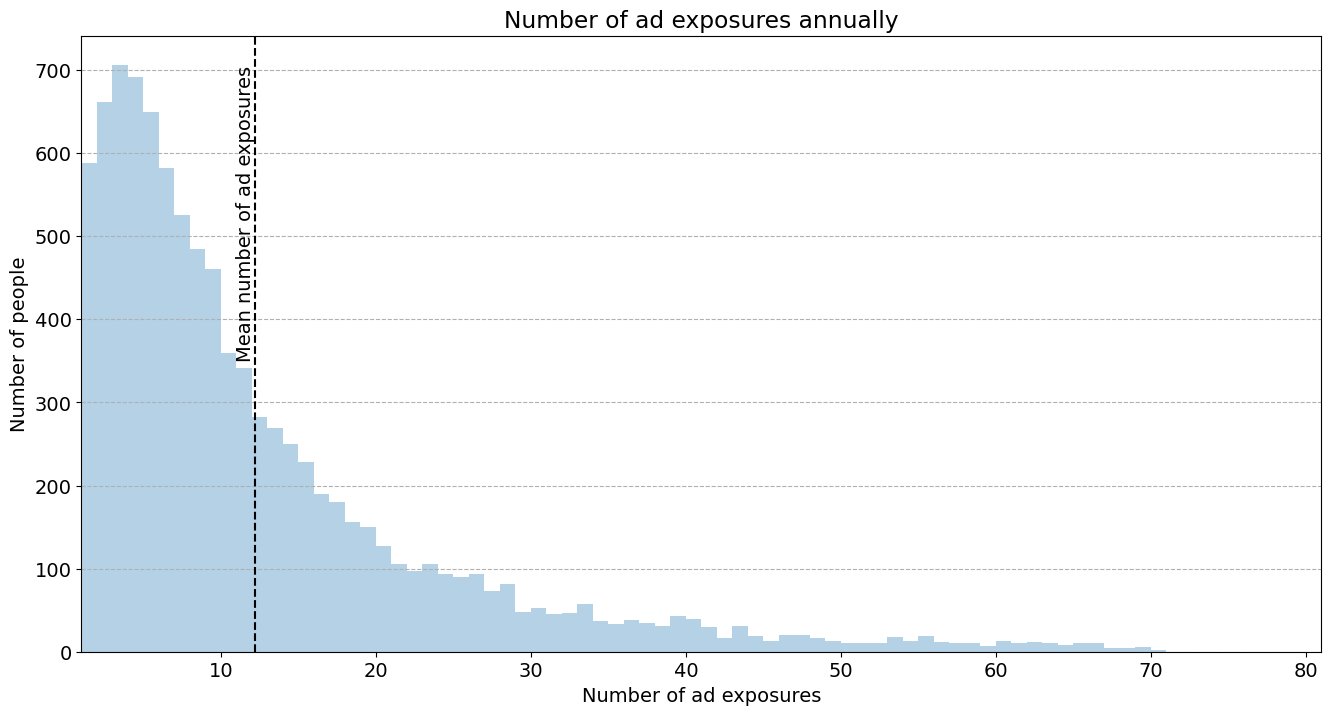

In [7]:
# 4. Visualize the distribution of total ad exposures annually for all viewers.
plot.events_overall_annually(
    event_counts=n_exposures_no_outliers,
    event_name="ad exposures",
)

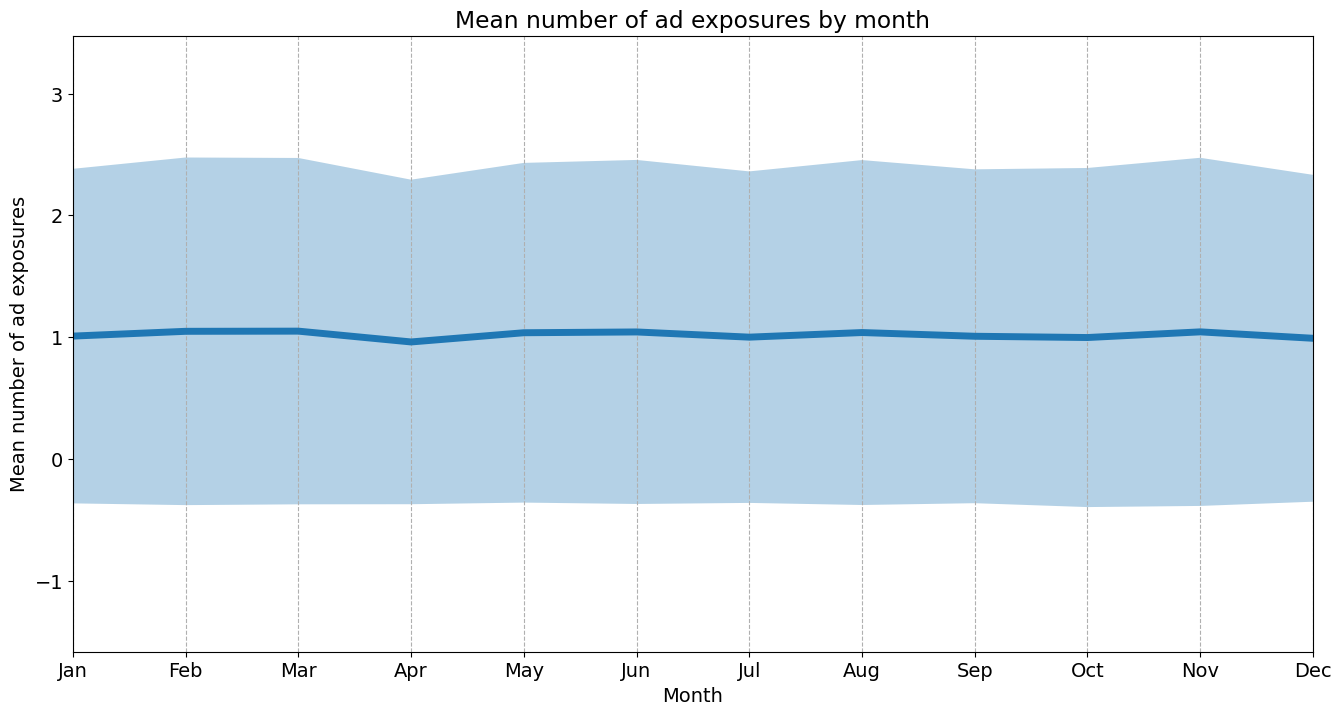

In [8]:
# 4. Visualize the distribution of total ad exposures by month for all viewers.
exposures_df_no_outliers = exposures_df.query("person in @n_exposures_no_outliers.index")
plot.events_overall_monthly(
    events_df=exposures_df_no_outliers,
    event_name="ad exposures",
    groupby=["person", "month"],
)

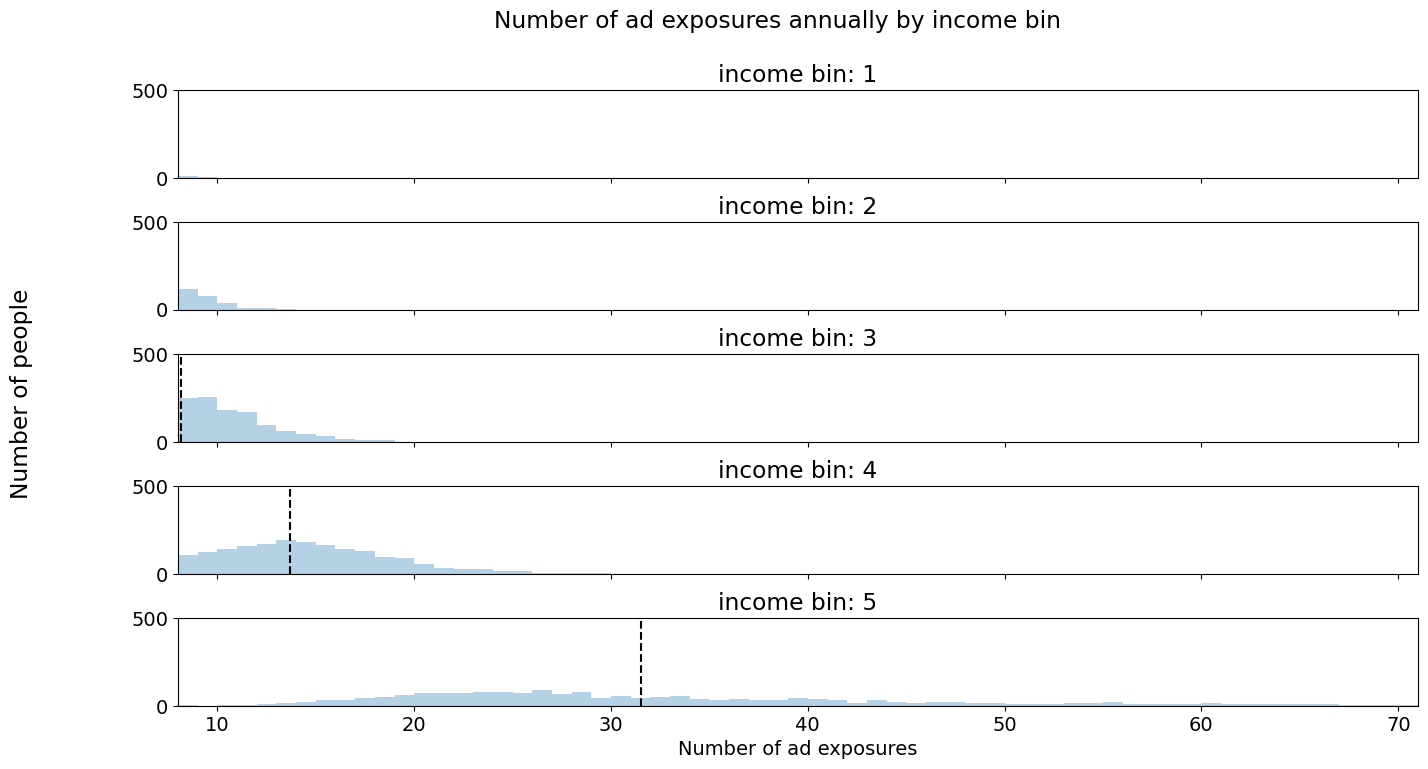

In [9]:
# 4. Visualize the distribution of total ad exposures annually for viewers of different income bins.
plot.events_subgroups_annually(
    events_df=exposures_df_no_outliers,
    event_name="ad exposures",
    groupby="income_bin",
)

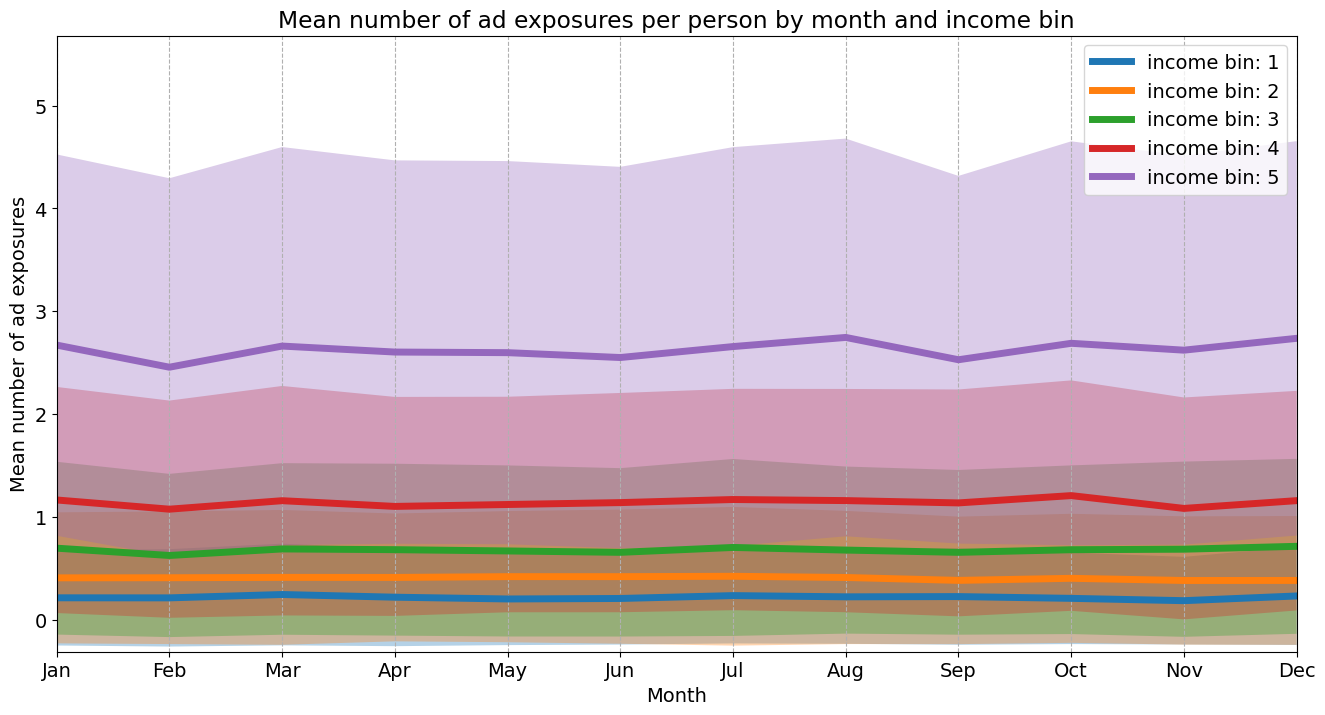

In [10]:
# 4. Visualize the distribution of total ad exposures by month for viewers of different income bins.
plot.events_subgroups_monthly(
    events_df=exposures_df_no_outliers,
    event_name="ad exposures",
    groupby="income_bin",
)

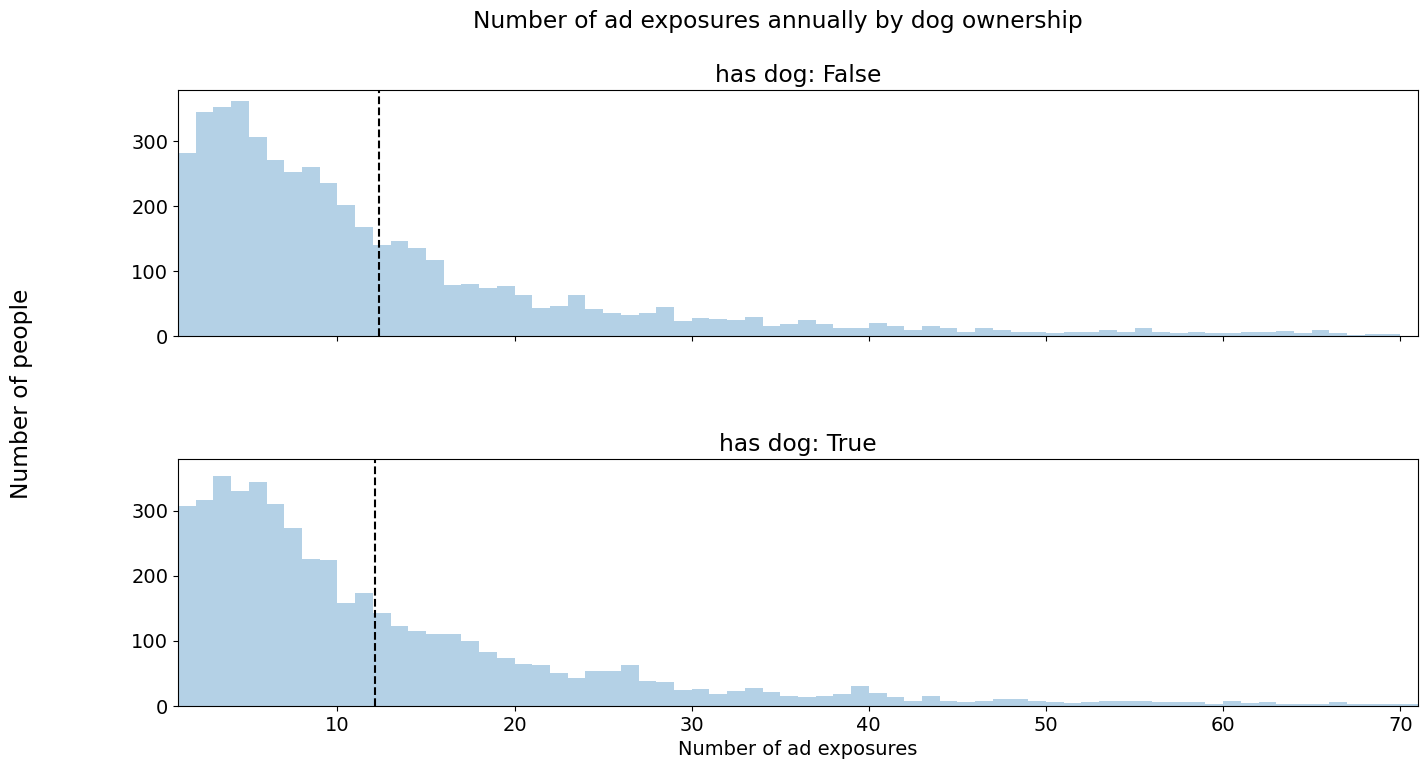

In [11]:
# 4. Visualize the distribution of total ad exposures annually for viewers with vs. without dogs.
plot.events_subgroups_annually(
    events_df=exposures_df_no_outliers,
    event_name="ad exposures",
    groupby="has_dog",
)

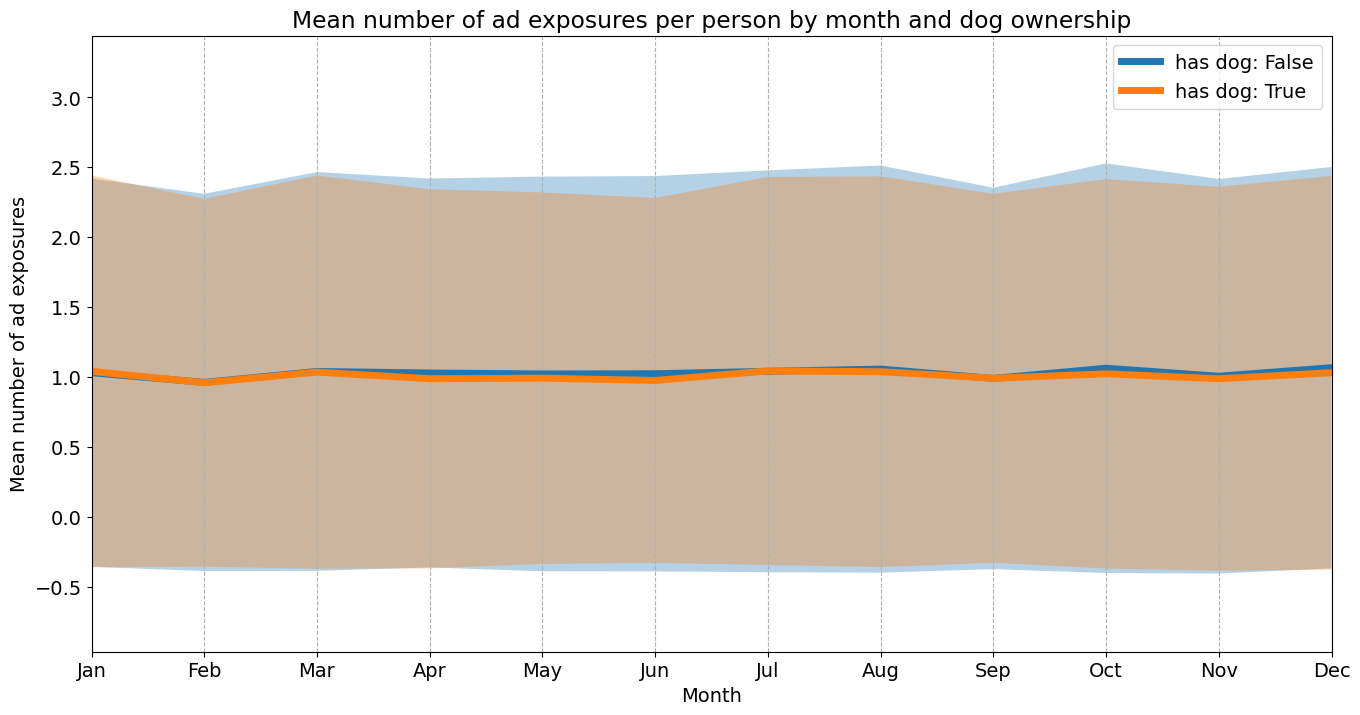

In [12]:
# 4. Visualize the distribution of total ad exposures by month for viewers with vs. without dogs.
plot.events_subgroups_monthly(
    events_df=exposures_df_no_outliers,
    event_name="ad exposures",
    groupby="has_dog",
)

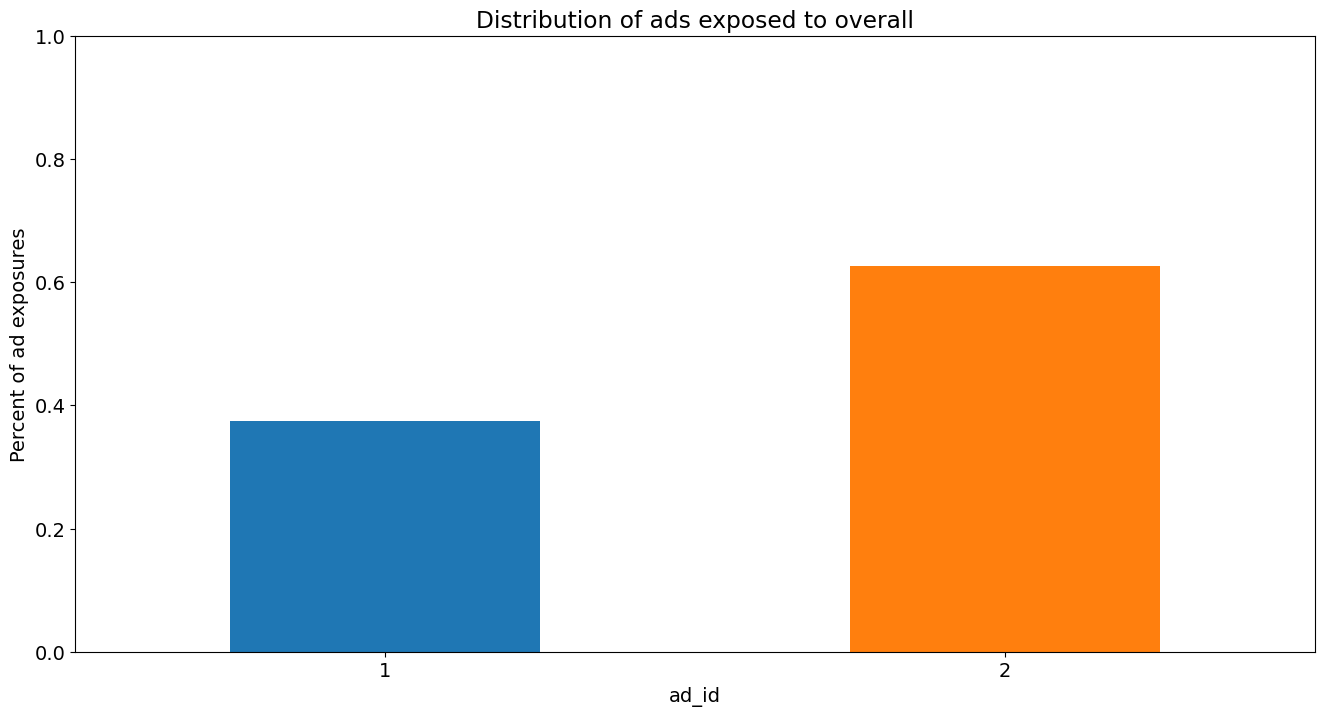

In [13]:
# 4. Visualize the distribution of ads exposed to anually for all viewers.
plot.ads_channels_overall_annually(
    events_df=exposures_df_no_outliers,
    event_name="ad exposures",
    groupby="ad_id",
    title="Distribution of ads exposed to overall",
)

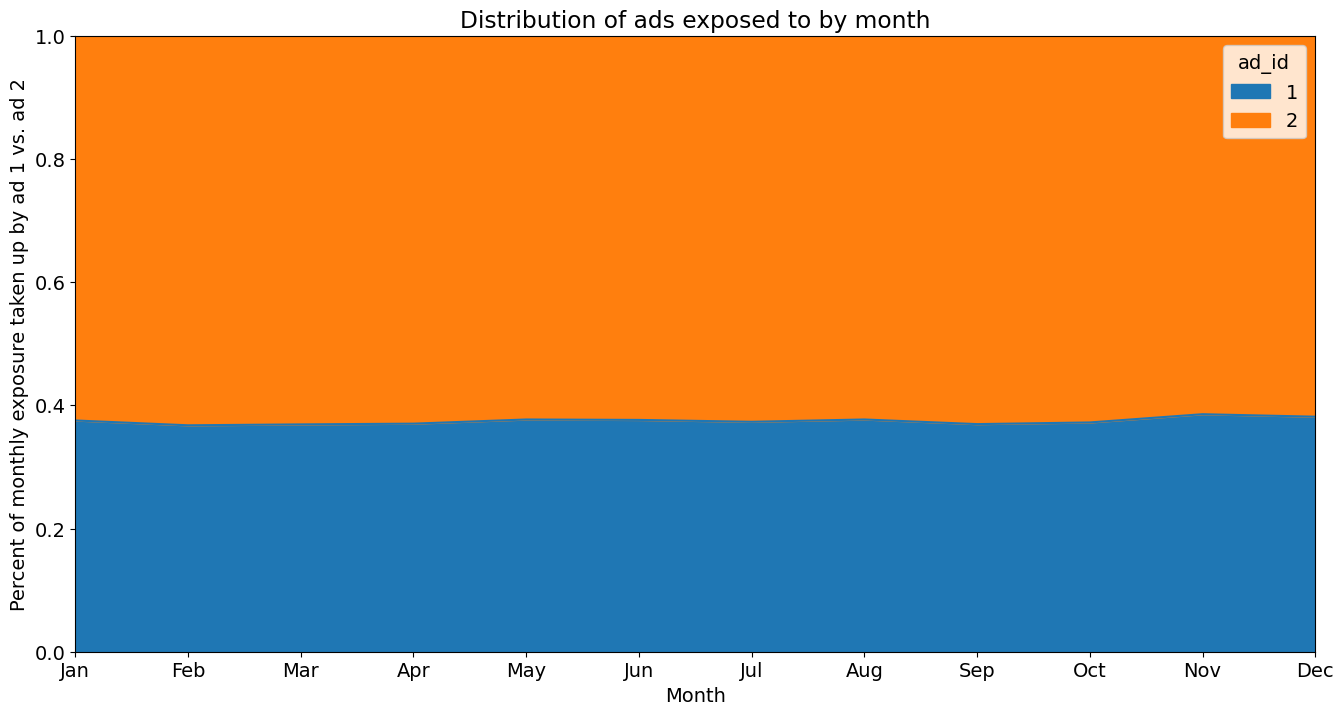

In [14]:
# 4. Visualize the distribution of ads exposed to by month for all viewers.
plot.ads_channels_overall_monthly(
    events_df=exposures_df_no_outliers,
    groupby="ad_id",
    title=f"Distribution of ads exposed to by month",
    ylabel="Percent of monthly exposure taken up by ad 1 vs. ad 2",
)

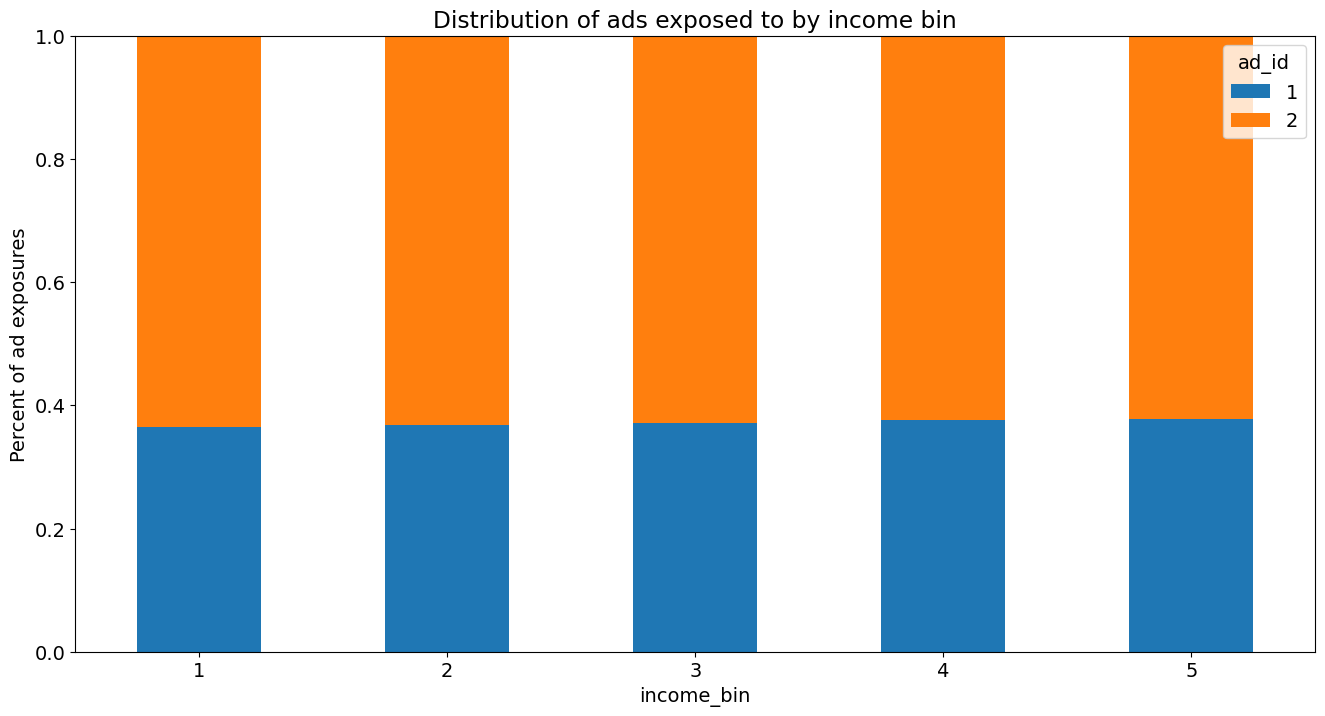

In [15]:
# 4. Visualize the distribution of ads exposed to anually for viewers of different income bins.
plot.ads_channels_subgroups_annually(
    events_df=exposures_df_no_outliers,
    event_name="ad exposures",
    groupby=["income_bin", "ad_id"],
    title="Distribution of ads exposed to by income bin",
)

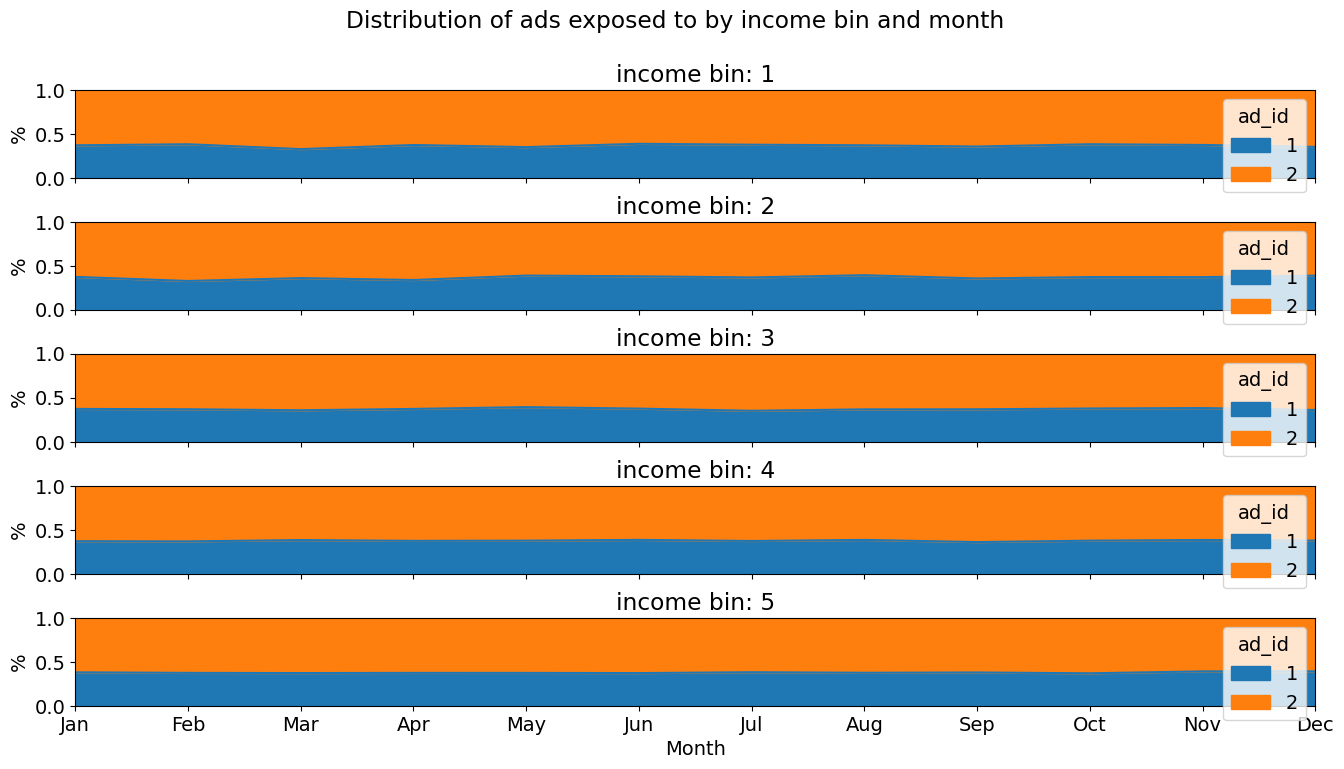

In [16]:
# 4. Visualize the distribution of ads exposed to by month for viewers of different income bins.
plot.ads_channels_subgroups_monthly(
    subgroups=exposures_df_no_outliers.groupby("income_bin"),
    groupby="ad_id",
    title="Distribution of ads exposed to by income bin and month",
)

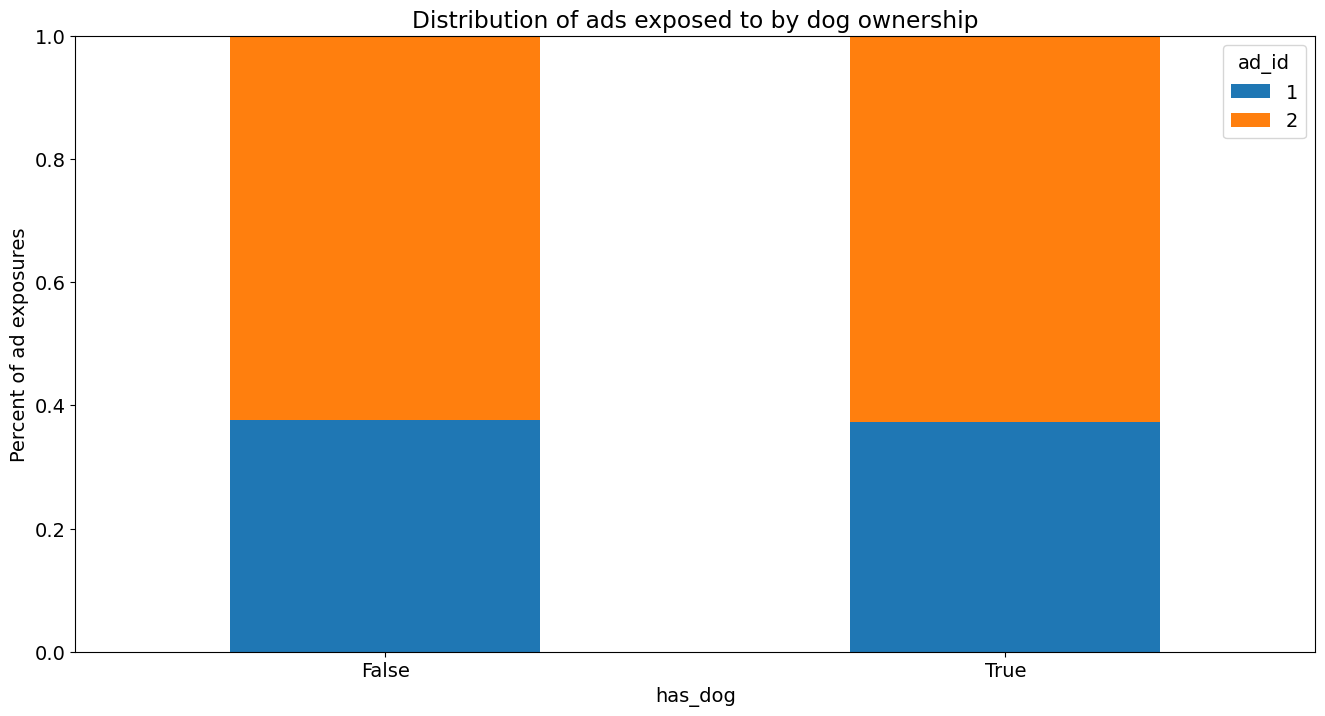

In [17]:
# 4. Visualize the distribution of ads exposed to annually for viewers with vs. without dogs.
plot.ads_channels_subgroups_annually(
    events_df=exposures_df_no_outliers,
    event_name="ad exposures",
    groupby=["has_dog", "ad_id"],
    title="Distribution of ads exposed to by dog ownership",
)

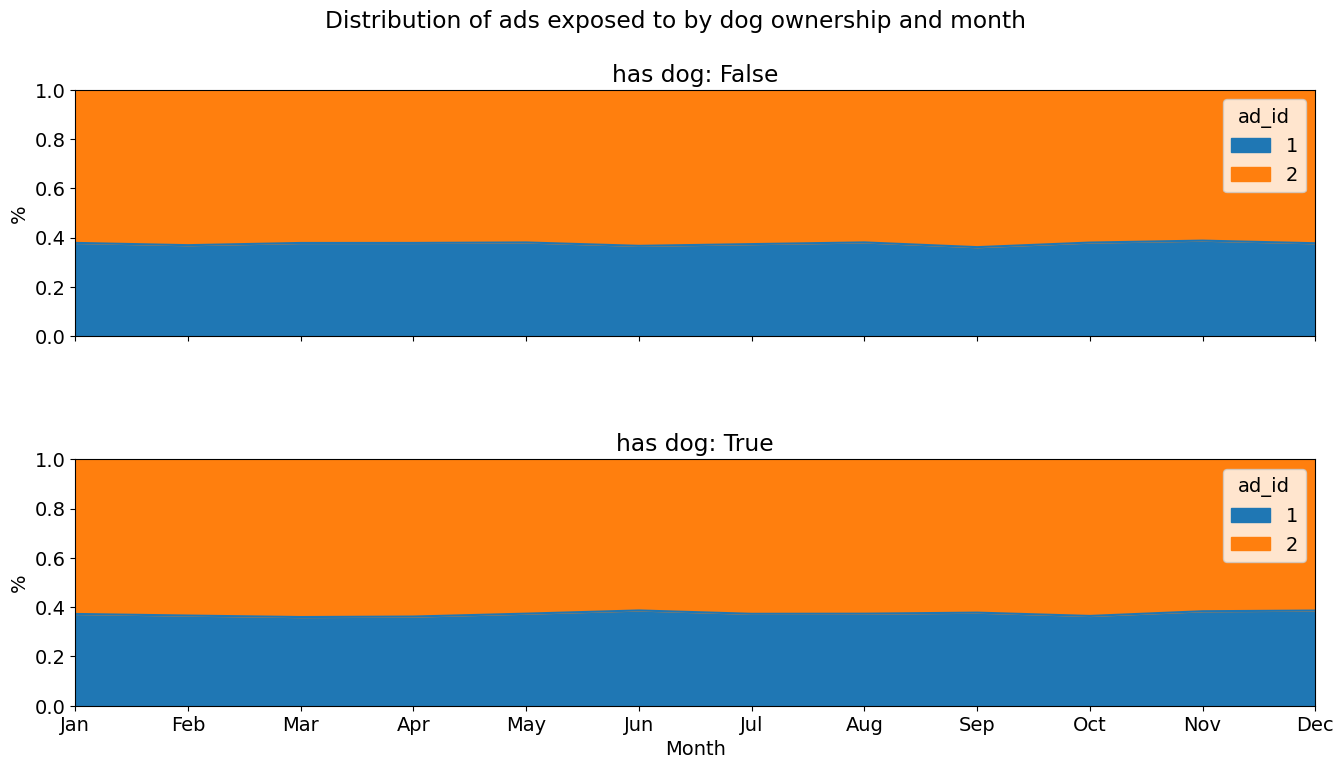

In [18]:
# 4. Visualize the distribution of ads exposed to by month for viewers with vs. without dogs.
plot.ads_channels_subgroups_monthly(
    subgroups=exposures_df_no_outliers.groupby("has_dog"),
    groupby="ad_id",
    title="Distribution of ads exposed to by dog ownership and month",
)

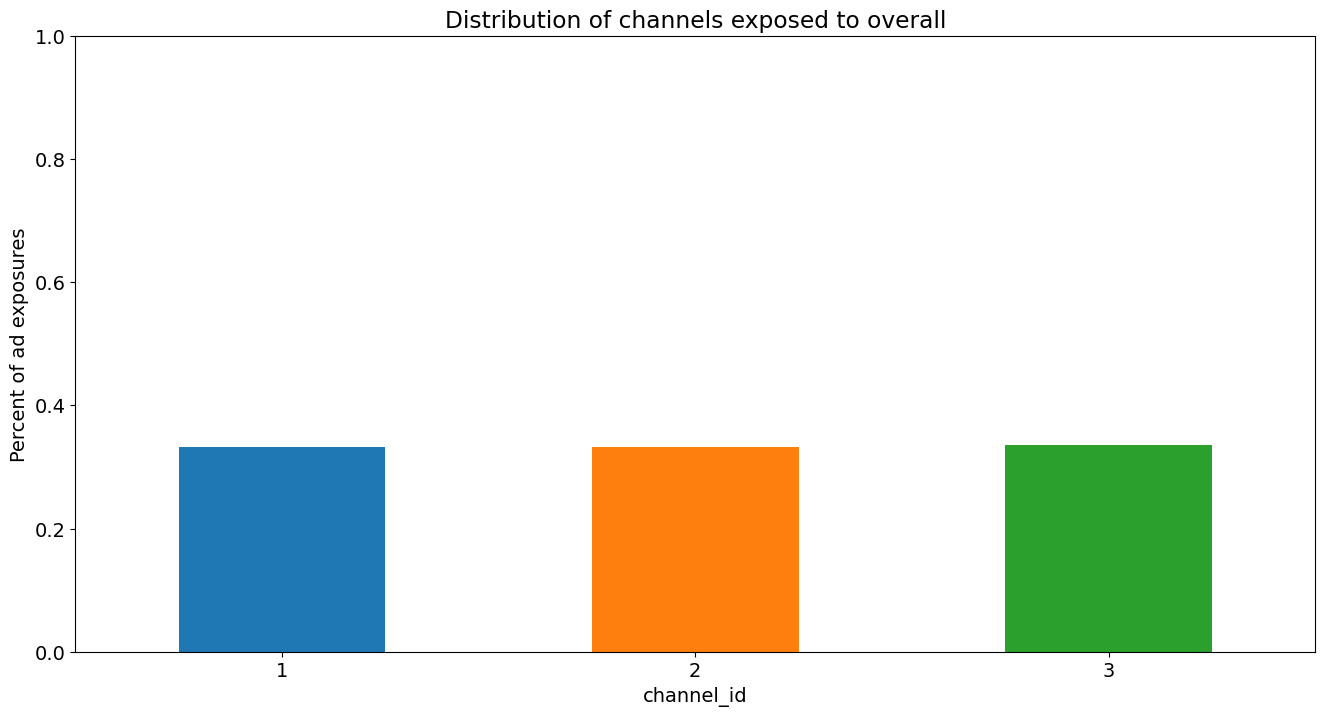

In [19]:
# 4. Visualize the distribution of channels exposed to anually for all viewers.
plot.ads_channels_overall_annually(
    events_df=exposures_df_no_outliers,
    event_name="ad exposures",
    groupby="channel_id",
    title="Distribution of channels exposed to overall",
)

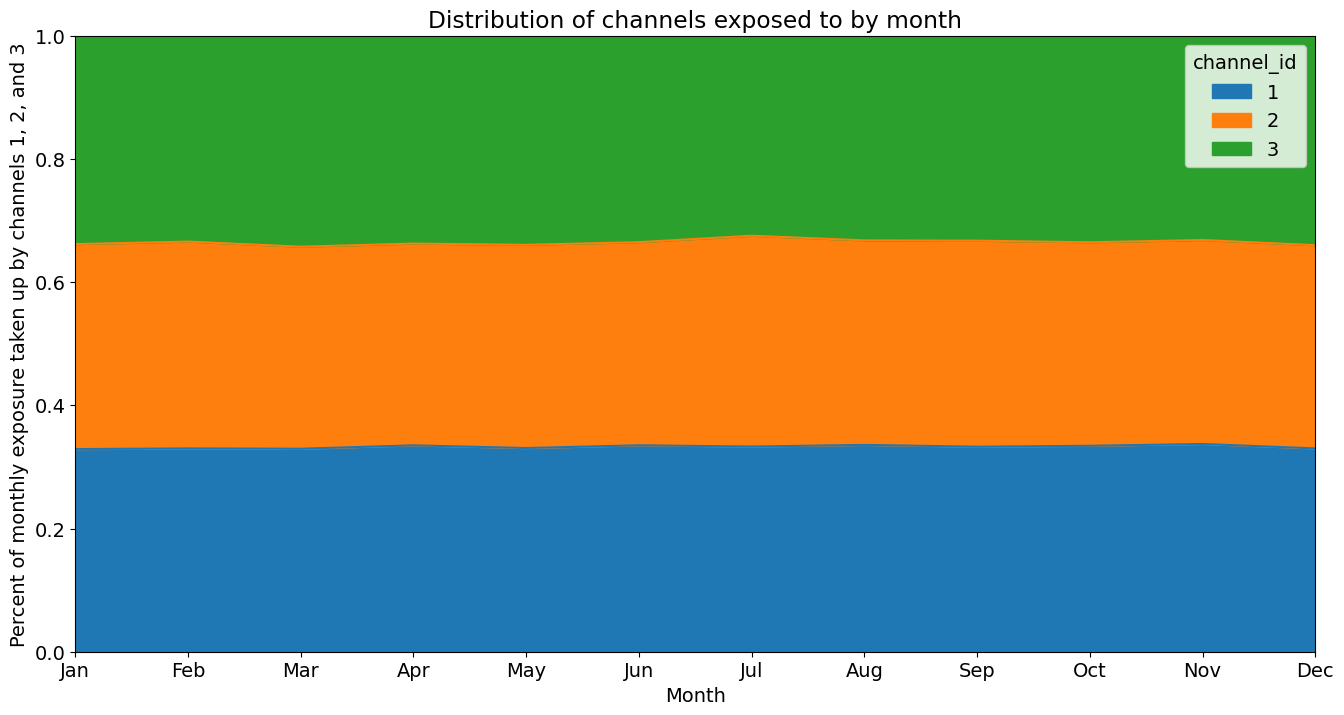

In [20]:
# 4. Visualize the distribution of channels exposed to by month for all viewers.
plot.ads_channels_overall_monthly(
    events_df=exposures_df_no_outliers,
    groupby="channel_id",
    title="Distribution of channels exposed to by month",
    ylabel="Percent of monthly exposure taken up by channels 1, 2, and 3",
)

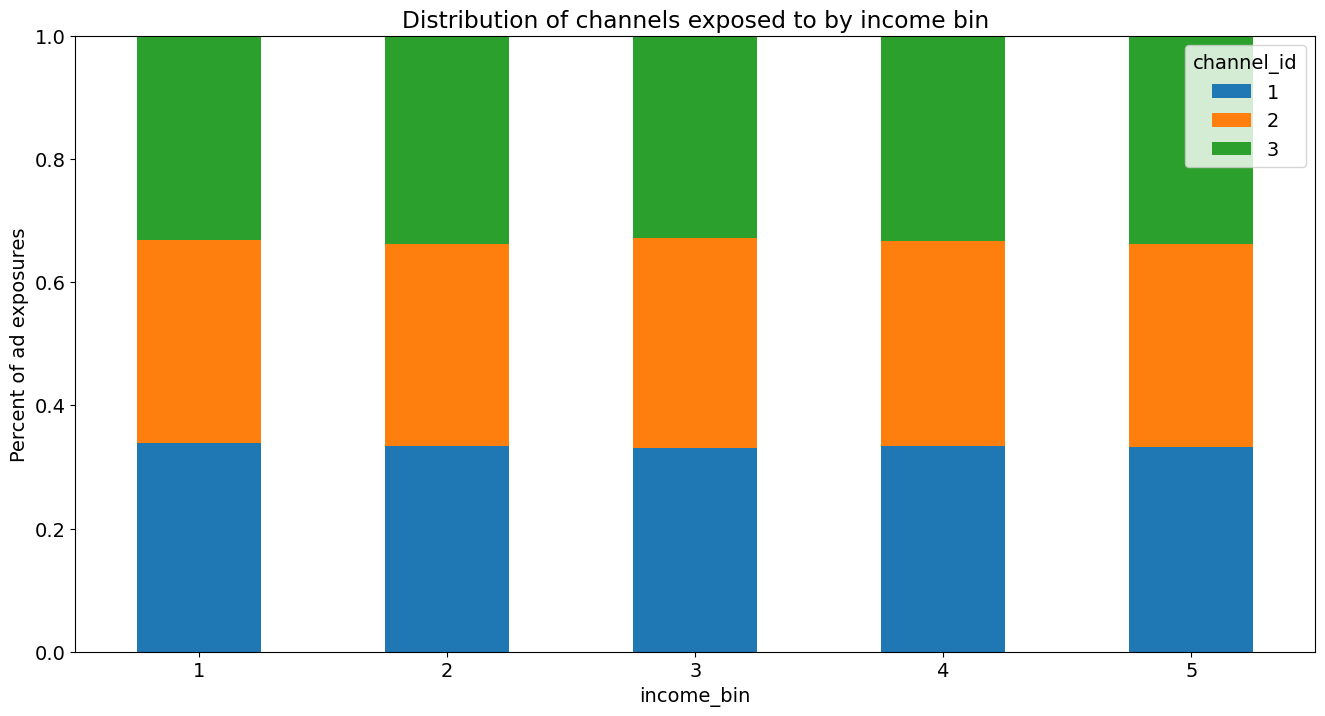

In [21]:
# 4. Visualize the distribution of channels exposed to anually for viewers of different income bins.
plot.ads_channels_subgroups_annually(
    events_df=exposures_df_no_outliers,
    event_name="ad exposures",
    groupby=["income_bin", "channel_id"],
    title="Distribution of channels exposed to by income bin",
)

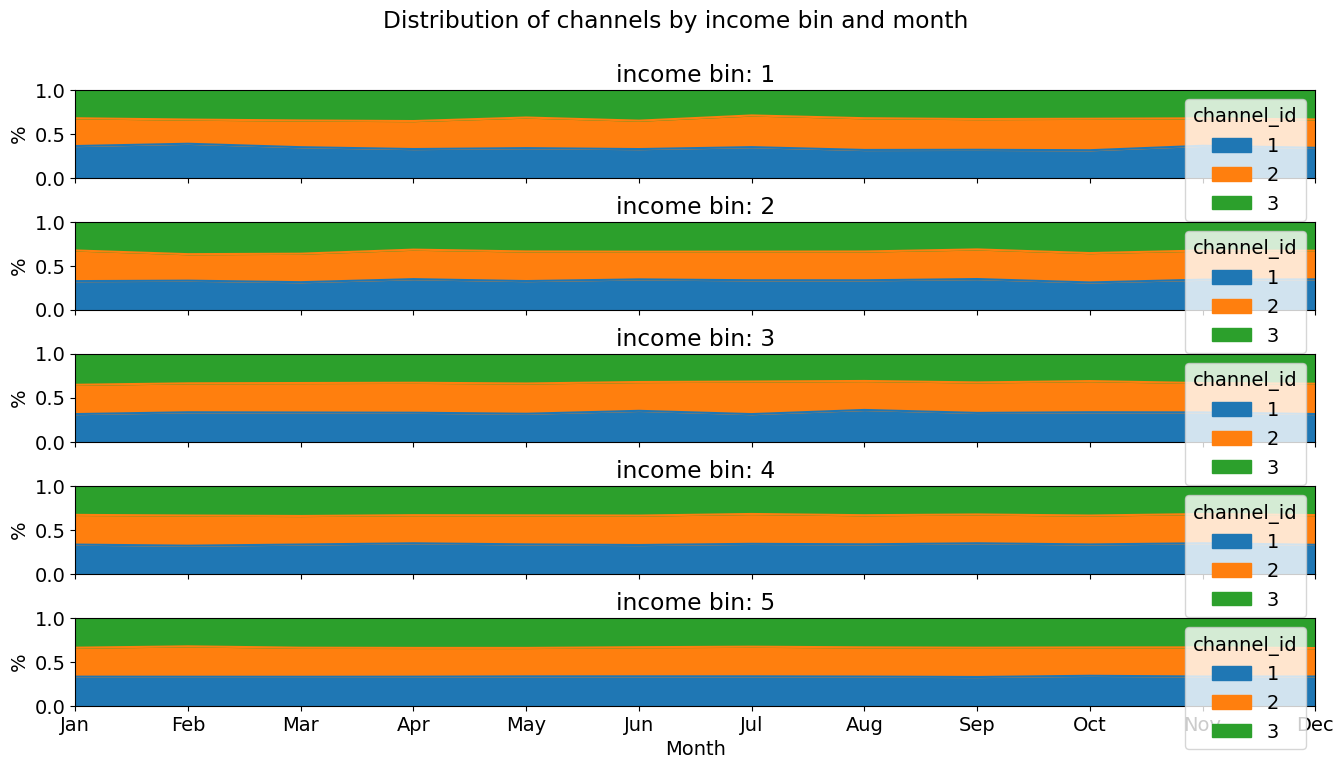

In [22]:
# 4. Visualize the distribution of channels exposed to by month for viewers of different income bins.
plot.ads_channels_subgroups_monthly(
    subgroups=exposures_df_no_outliers.groupby("income_bin"),
    groupby="channel_id",
    title="Distribution of channels by income bin and month",
)

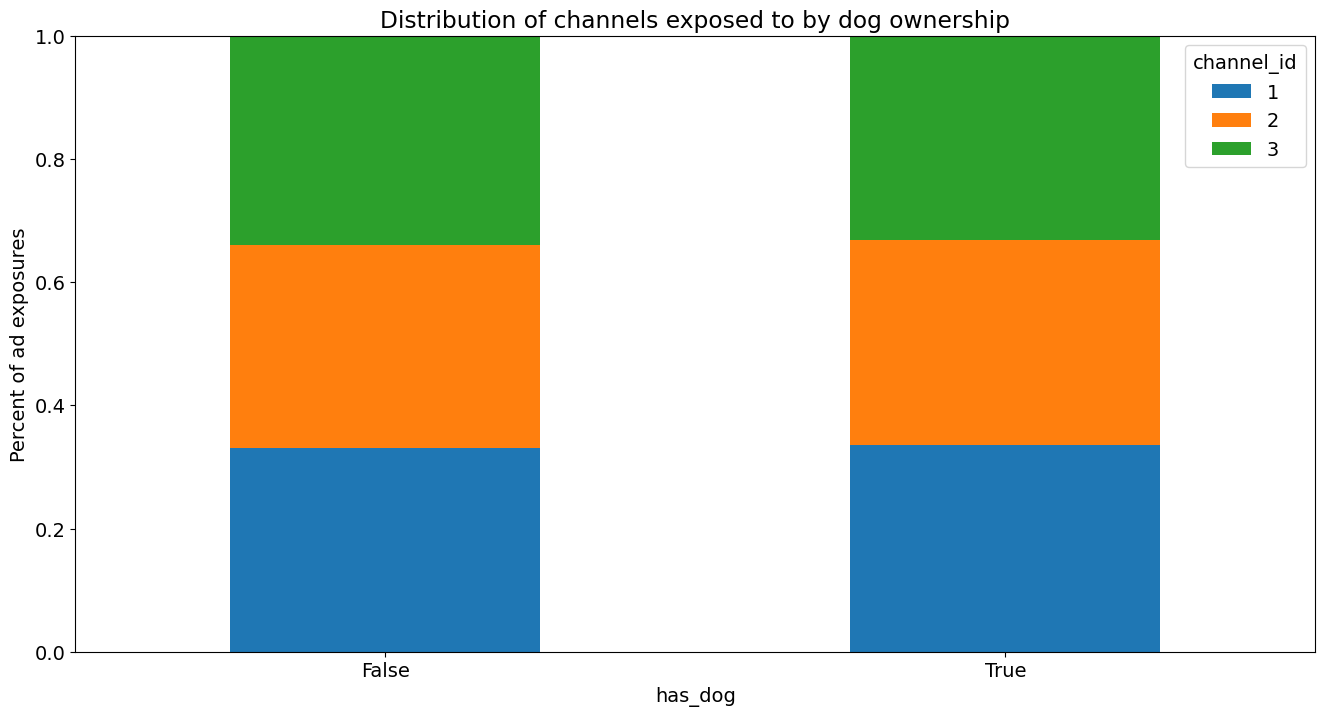

In [23]:
# 4. Visualize the distribution of channels exposed to anually for viewers of different income bins.
plot.ads_channels_subgroups_annually(
    events_df=exposures_df_no_outliers,
    event_name="ad exposures",
    groupby=["has_dog", "channel_id"],
    title="Distribution of channels exposed to by dog ownership",
)

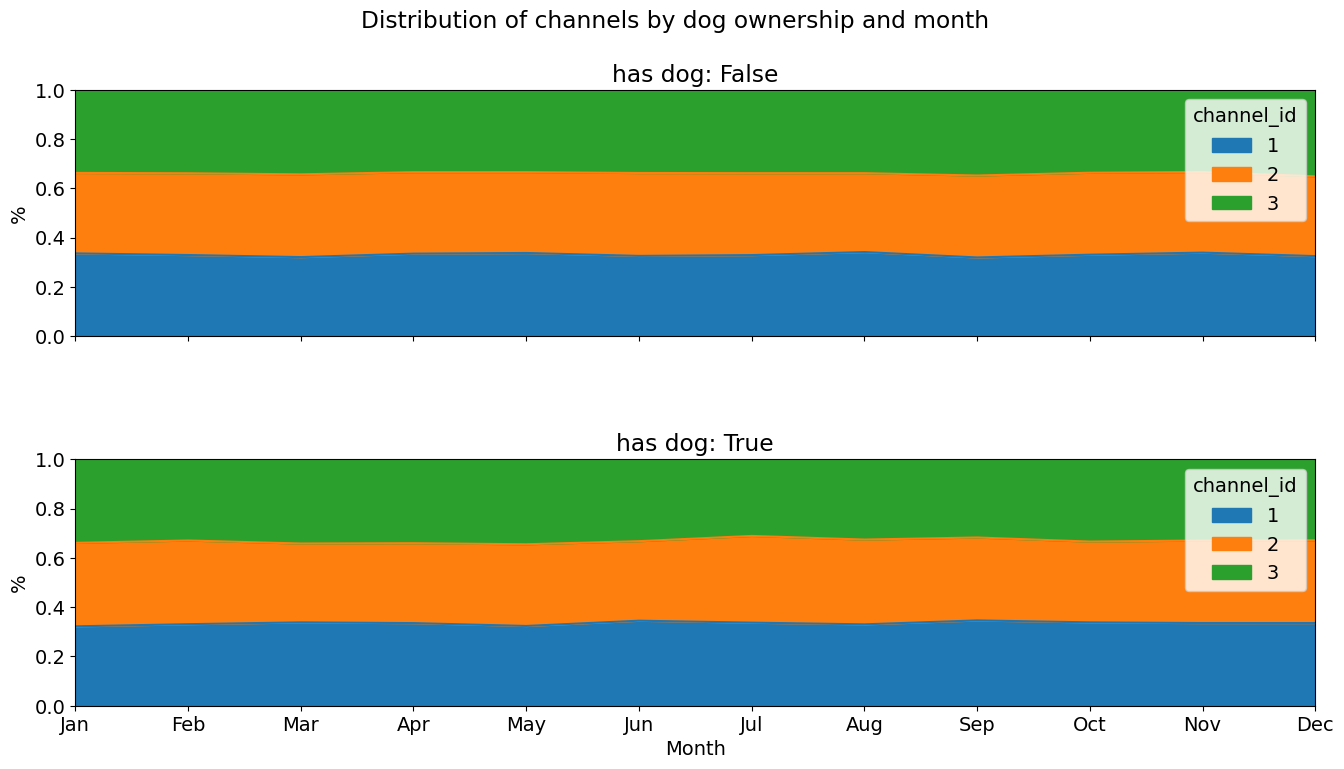

In [24]:
# 4. Visualize the distribution of channels exposed to by month for viewers with vs. without dogs.
plot.ads_channels_subgroups_monthly(
    subgroups=exposures_df_no_outliers.groupby("has_dog"),
    groupby="channel_id",
    title="Distribution of channels by dog ownership and month",
)

### Question 1: Key observations and takeaways

- The dataset is extremely homogenous overall, with very little in the way of trends that a model could exploit during learning.
- Ad exposures remain stable throughout the year. "Typical" exposure rates in month X appear comparable to "typical" exposure rates in month Y, for any X and Y.
- Segmenting the data by dog ownership yields little of interest. Owners and non-owners were exposed to ads at similar rates throughout the year.
- Segmenting the data by income yielded slightly more value, in that rates of ad exposure do seem to covary proportionally with income bin. This suggests models could learn from this feature.
  - However, income bins are quite imbalanced, which may lead to poor performance on the margins for less-represented bins.

----
## Question 2: How often do people visit the website?

### Methodology

1. Join `people` and `site_visits` data on `person` ID.
2. Compute how many times each person visited the website.
3. Drop outliers.
   - **NOTE:** Outliers are defined as people whose number of annual site visits differed from the mean by three standard deviations.
4. Visualize the distribution of total site visits in two interacting ways:
   - Annual snapshot - aggregate statistics computed across the entire dataset irrespective of time.
   - Monthly snapshot - statistics computed within each month, showing how trends change throughout the year.

For Step 4, analyses will be conducted both "overall" (i.e., with all records lumped together, irrespective of subgroup) and within subgroups (namely comparing income brackets and dog ownership).

In [25]:
# 1. Join `people` and `site_visits` data on `person` ID.
site_visits_df = join_dfs(dfs, "site_visits")

,person,demog3,demog4,income_bin,has_dog,time,month
0,1,1.018087,-0.027245,2,True,2020-01-09 20:53:03+00:00,Jan
1,1,1.018087,-0.027245,2,True,2020-02-13 06:51:18+00:00,Feb
2,1,1.018087,-0.027245,2,True,2020-03-12 17:41:47+00:00,Mar
3,1,1.018087,-0.027245,2,True,2020-04-30 03:01:20+00:00,Apr
4,1,1.018087,-0.027245,2,True,2020-05-24 19:35:21+00:00,May


In [26]:
# 2. Compute how many times each person visited the website.
n_site_visits = count_events(site_visits_df, "site_visits", show=True)

,n_site_visits
person,
1,9
2,8
3,8
4,7
5,9


In [27]:
# 3. Drop outliers.
n_site_visits_no_outliers = n_site_visits.loc[~is_outlier(n_site_visits)]

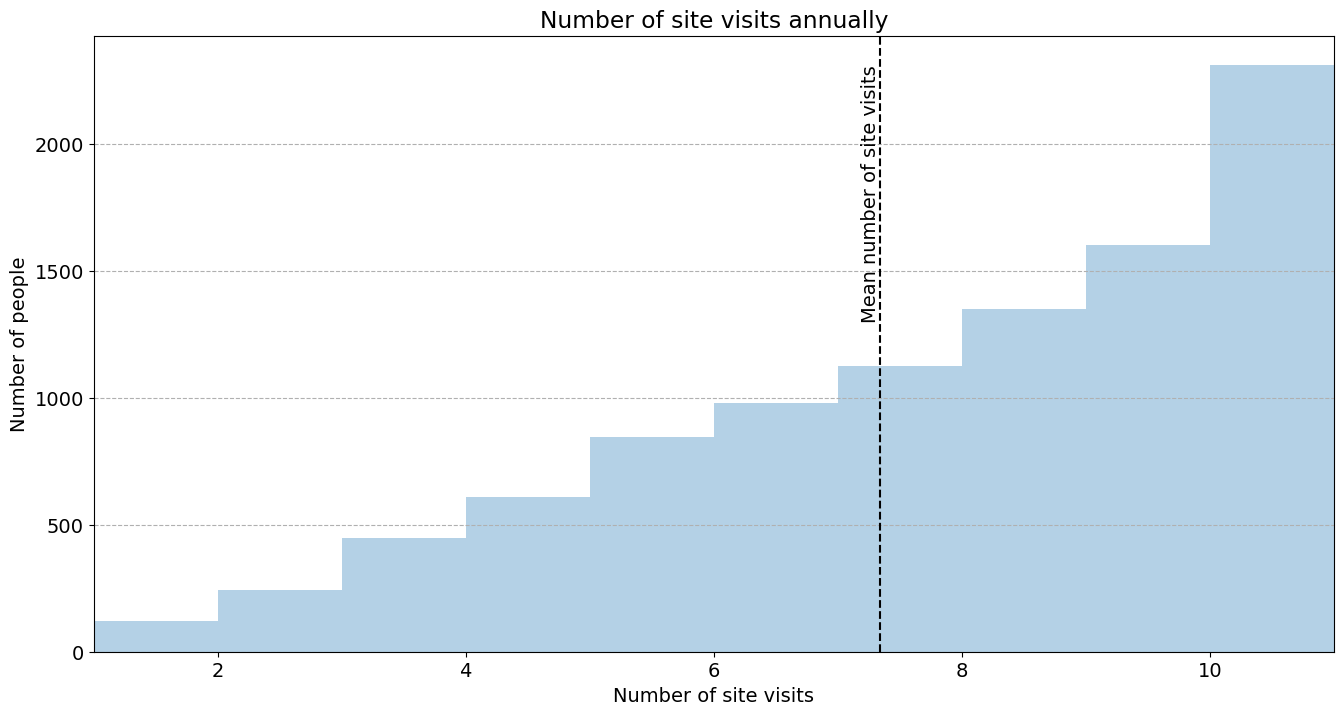

In [28]:
# 4. Visualize the distribution of total site visits annually for all viewers.
plot.events_overall_annually(
    event_counts=n_site_visits_no_outliers,
    event_name="site visits",
)

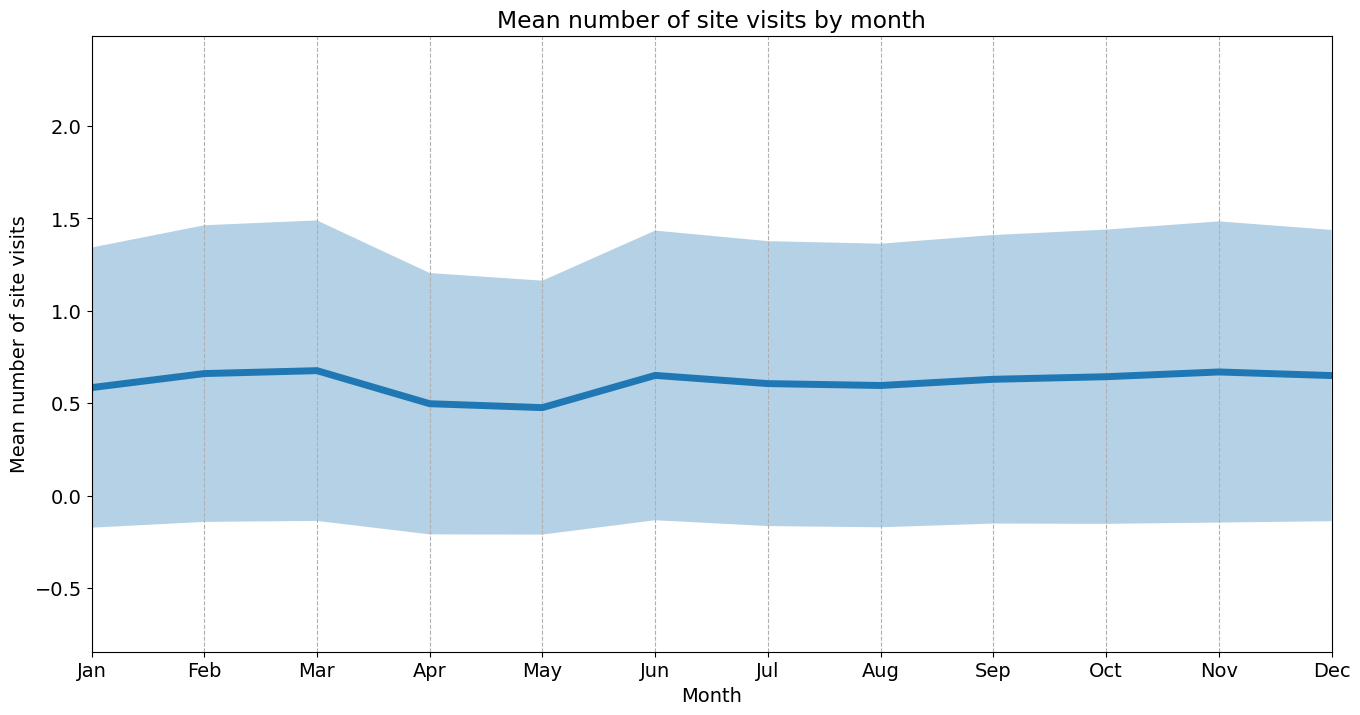

In [29]:
# 4. Visualize the distribution of total site visits by month for all viewers.
site_visits_df_no_outliers = site_visits_df.query("person in @n_site_visits_no_outliers.index")
plot.events_overall_monthly(
    events_df=site_visits_df_no_outliers,
    event_name="site visits",
    groupby=["person", "month"],
)

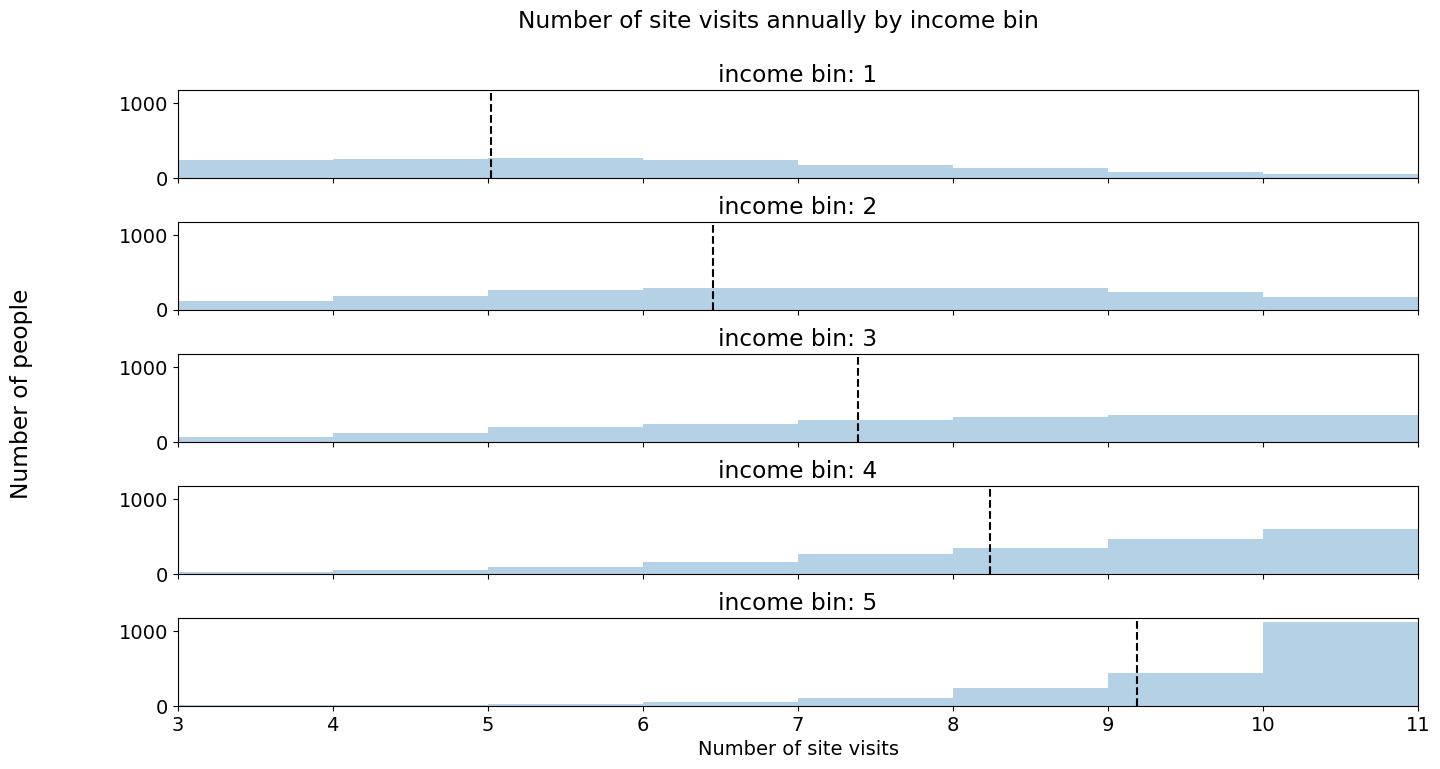

In [30]:
# 4. Visualize the distribution of total site visits annually for viewers of different income bins.
plot.events_subgroups_annually(
    events_df=site_visits_df_no_outliers,
    event_name="site visits",
    groupby="income_bin",
)

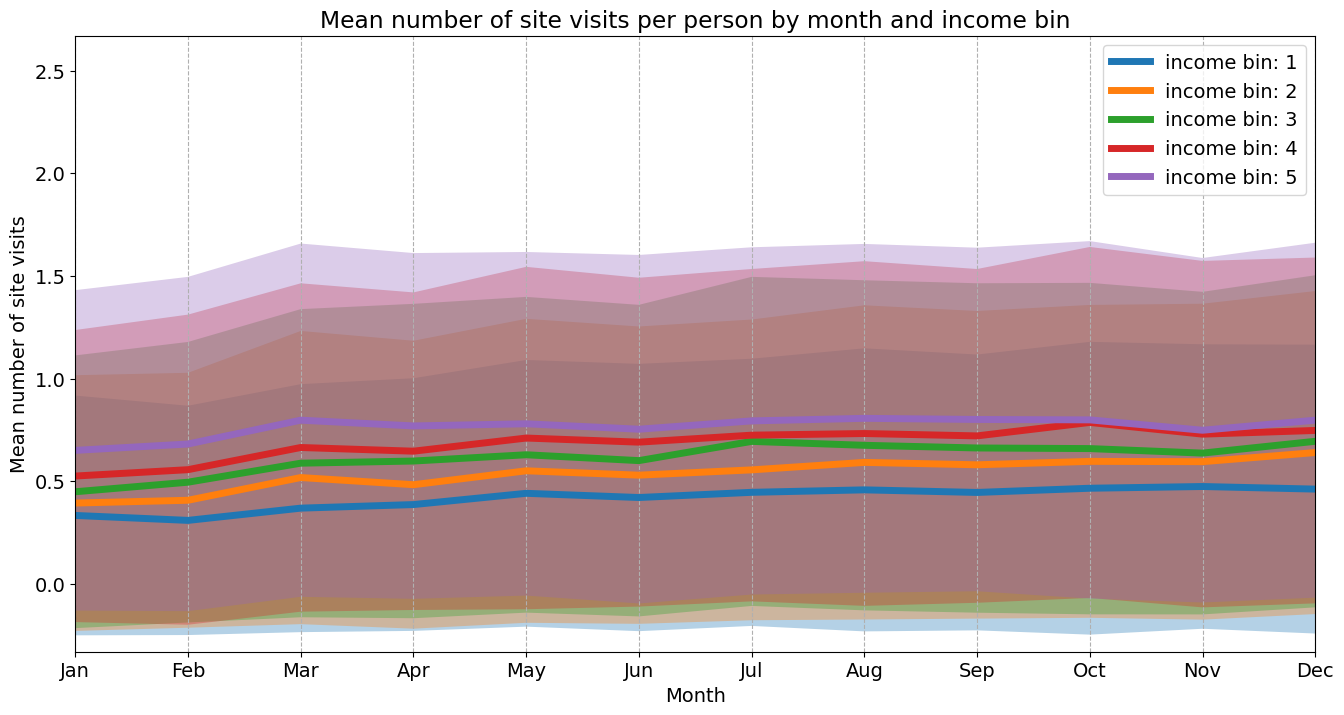

In [31]:
# 4. Visualize the distribution of total site visits by month for viewers of different income bins.
plot.events_subgroups_monthly(
    events_df=site_visits_df_no_outliers,
    event_name="site visits",
    groupby="income_bin",
)

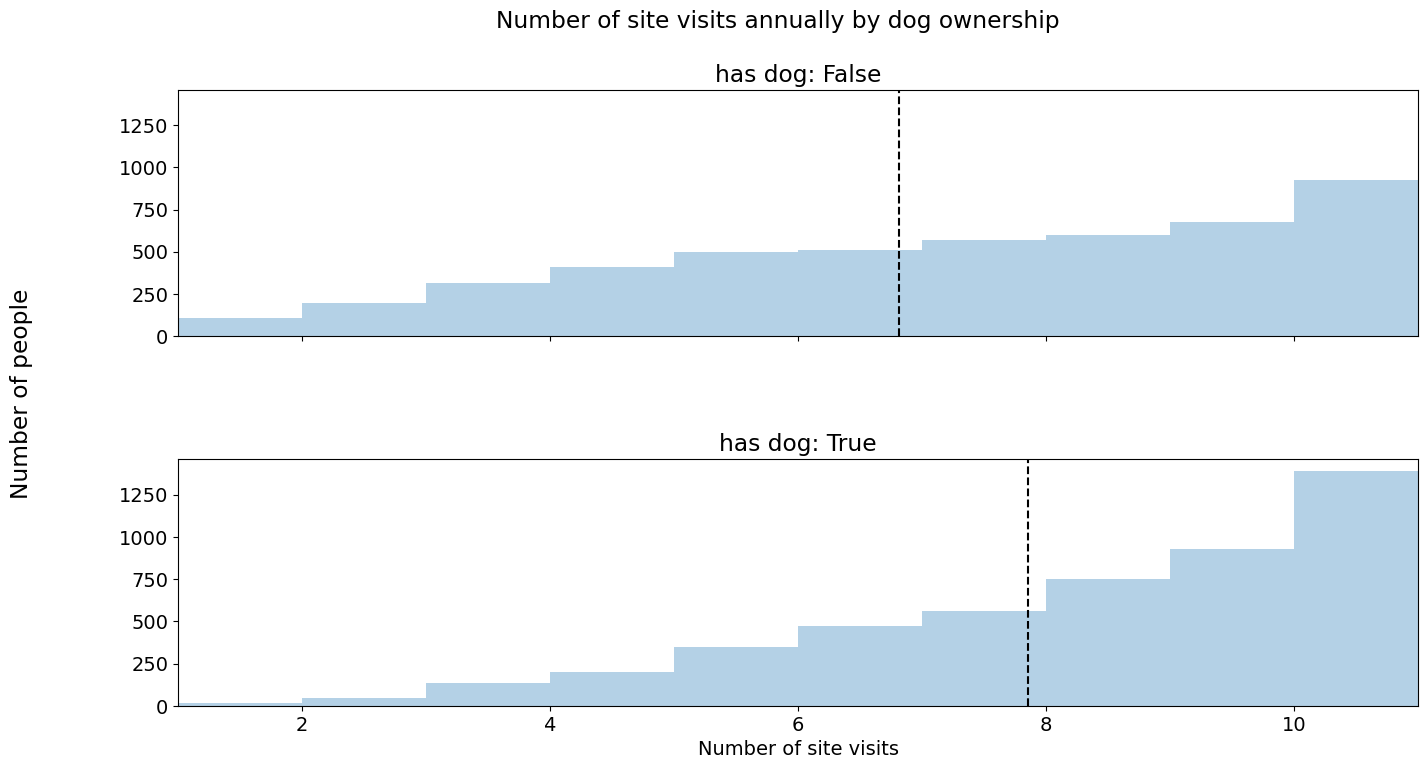

In [32]:
# 4. Visualize the distribution of total site visits annually for viewers with vs. without dogs.
plot.events_subgroups_annually(
    events_df=site_visits_df_no_outliers,
    event_name="site visits",
    groupby="has_dog",
)

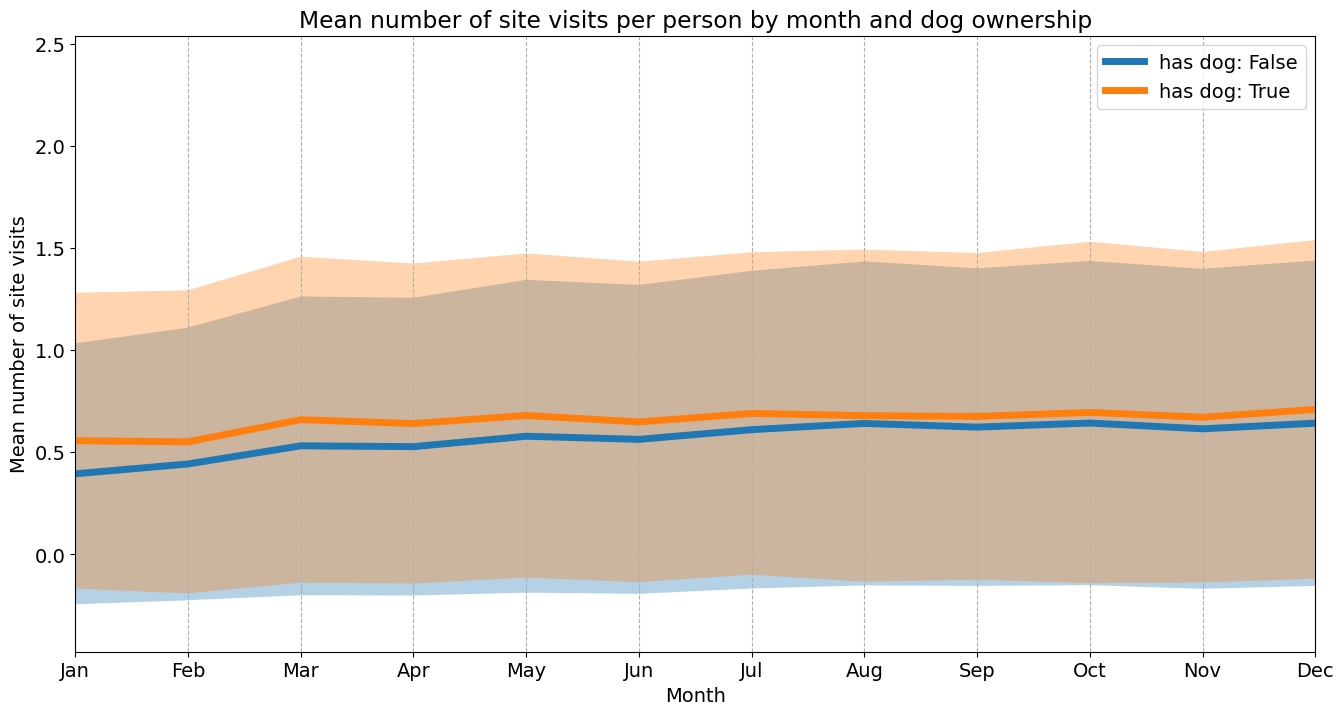

In [33]:
# 4. Visualize the distribution of total site visits by month for viewers with vs. without dogs.
plot.events_subgroups_monthly(
    events_df=site_visits_df_no_outliers,
    event_name="site visits",
    groupby="has_dog",
)

### Question 2: Key observations and takeaways

The conclusions for site visits are very similar to those for ad exposures investigated in Question 1. But I will enumerate them here all the same.

- Site visit trends are extremely homogenous overall.
- Site visits remain stable throughout the year. "Typical" visitation rates in month X appear comparable to "typical" visitation rates in month Y, for any X and Y.
- Segmenting the data by dog ownership yields little of interest. Owners and non-owners visited the site at similar rates throughout the year.
  - Dog owners do visit slightly more often, but it's unclear if this difference is statistically significant.
    - I did not perform that analysis because I don't believe this feature will be useful to the model anyway.
- Segmenting the data by income yielded slightly more value, in that visitation rates do seem to covary proportionally with income bin. This suggests models could learn from this feature.
  - However, income bins are quite imbalanced, which may lead to poor performance on the margins for less-represented bins.

----
## Question 3: How are the demographics distributed?

### Methodology

1. Visualize the distribution of `demog3` and `demog4` features by income bin subgroup.
2. Visualize the distribution of `demog3` and `demog4` features by dog ownership subgroup.

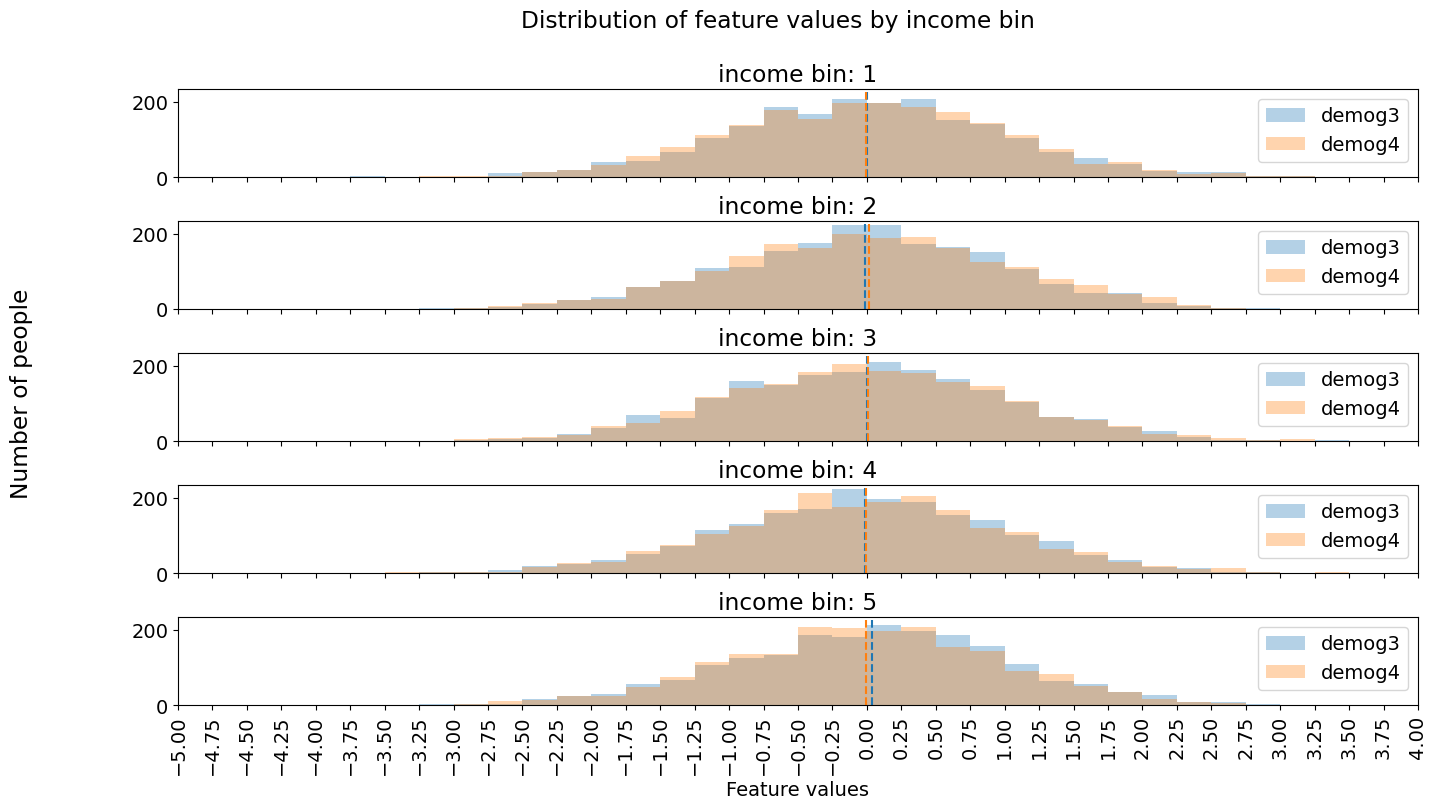

In [34]:
# 1. Visualize the distribution of `demog3` and `demog4` features by income bin.
demographic_features_df = dfs["people"].filter(like="demog")
plot.demographic_features_subgroups(
    demographic_features_df=dfs["people"].filter(like="demog"),
    subgroups=dfs["people"].groupby("income_bin"),
)

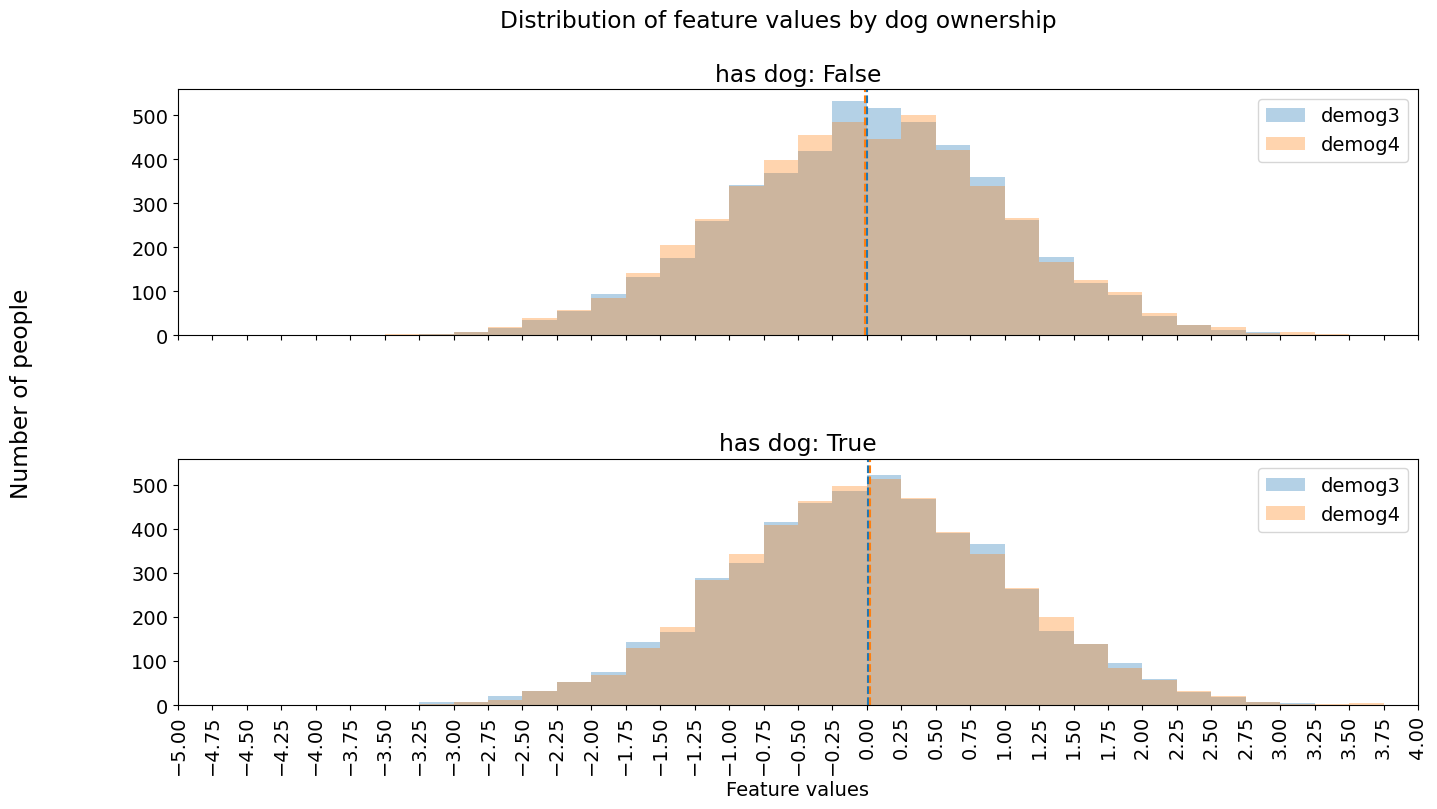

In [35]:
# 1. Visualize the distribution of `demog3` and `demog4` features by dog ownership.
plot.demographic_features_subgroups(
    demographic_features_df=demographic_features_df,
    subgroups=dfs["people"].groupby("has_dog"),
)

### Question 3: Key observations and takeaways

- The `demog3` and `demog4` features are normally distributed.
  - I wonder if these values have undergone some transformations, e.g., standardization.
- Their distributions are the same for all subgroups.
- It would help to know what these features are, but on the basis of the distributions alone, I do not believe these features will be valuable during modeling.

# Part 3: Train Exposure Prediction Model
----

----
## Question 4: What is the distribution of predicted exposure values?

### Methodology

1. Split data (90/10).
2. Remove outliers from the train set.
3. Plot feature and label covariances to understand relationships.
4. Conduct grid search over multiple model architectures and hyperparameter configurations.
5. Using the best-performing model for each architecture, plot predictions on the test set.
6. Visualize most predictive features.

In [36]:
train_df, test_df = split_data(
    features=dfs["people"].set_index("person"),
    labels=dfs["exposures"].person.value_counts().to_frame("y_true"),
)

,demog3,demog4,income_bin,has_dog,y_true
person,,,,,
245,0.302593,-0.974734,4.000000,0.000000,15.000000
4534,-0.304634,-0.658943,3.000000,0.000000,6.000000
2744,0.560937,0.341086,2.000000,1.000000,4.000000
6383,0.636643,0.446669,5.000000,0.000000,25.000000
9509,1.145171,1.965074,4.000000,1.000000,7.000000
,demog3,demog4,income_bin,has_dog,y_true
person,,,,,
1392,1.005957,0.347985,2.000000,0.000000,3.000000
614,0.530716,1.202145,2.000000,1.000000,7.000000


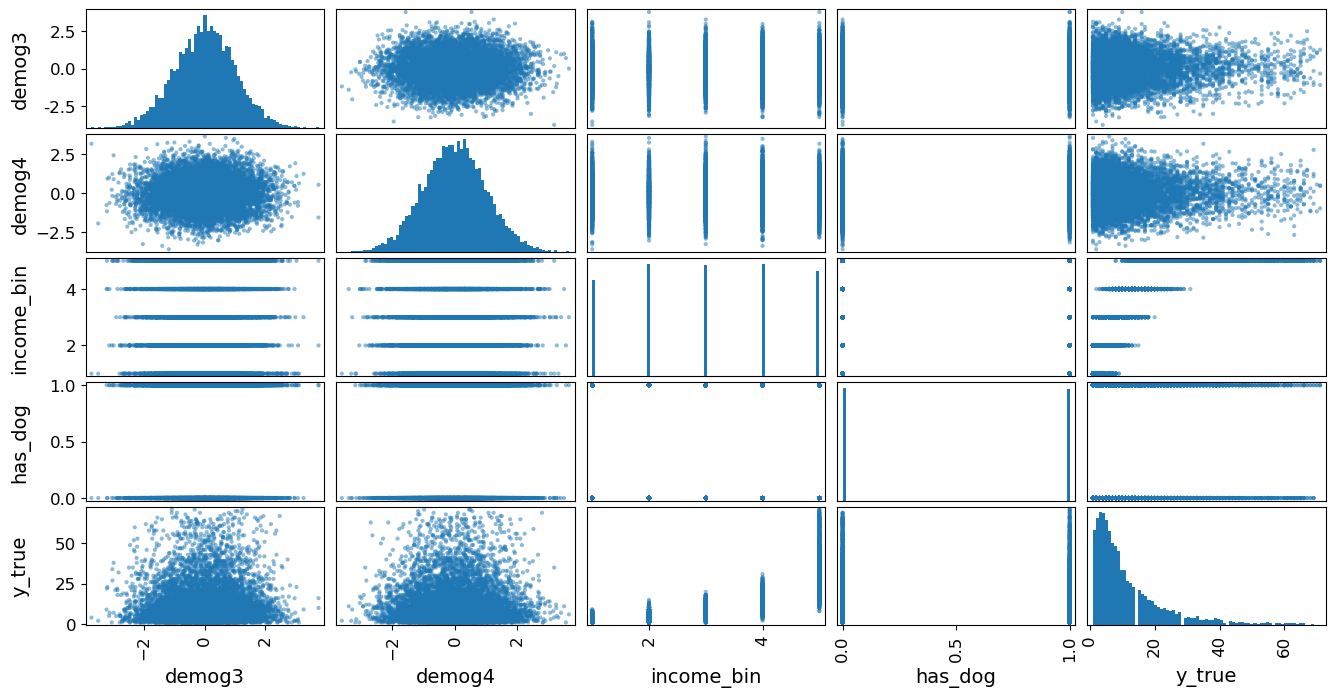

In [37]:
plot.feature_covariances(train_df)

In [38]:
X_train, y_train, X_test, y_test = preprocess(
    train_df=train_df,
    test_df=test_df,
)

Train features shape: (8568, 4)
Train labels shape: (8568,)
Test features shape: (967, 4)
Test labels shape: (967,)


In [39]:
best_models = run_gridsearch(
    X_train=X_train,
    y_train=y_train,
    pipelines=configure_pipelines(),
)

Running grid search for KNeighborsRegressor...
Best model for KNeighborsRegressor:
{
    "model": "KNeighborsRegressor",
    "model__n_neighbors": 10,
    "model__p": 1,
    "model__weights": "uniform"
}
Best MAE for KNeighborsRegressor: 0.3170
Running grid search for Lasso...
Best model for Lasso:
{
    "model": "Lasso",
    "model__alpha": 0.001,
    "model__fit_intercept": true
}
Best MAE for Lasso: 0.3082
Running grid search for LinearRegression...
Best model for LinearRegression:
{
    "model": "LinearRegression",
    "model__fit_intercept": true
}
Best MAE for LinearRegression: 0.3082
Running grid search for RandomForestRegressor...
Best model for RandomForestRegressor:
{
    "model": "RandomForestRegressor",
    "model__max_depth": 10,
    "model__n_estimators": 100
}
Best MAE for RandomForestRegressor: 0.3091
Running grid search for SVR...
Best model for SVR:
{
    "model": "SVR",
    "model__C": 1,
    "model__epsilon": 0.01,
    "model__kernel": "rbf"
}
Best MAE for SVR: 0.30

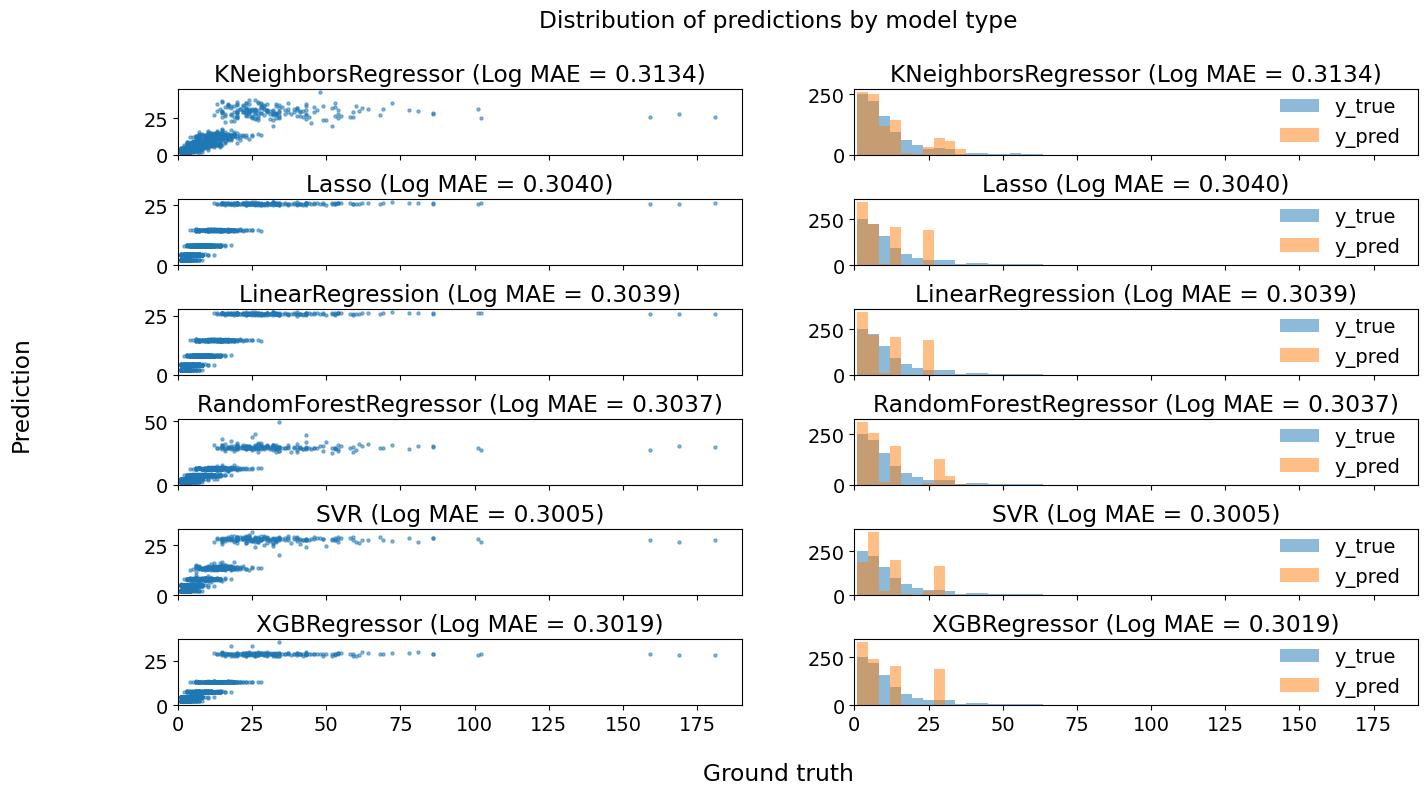

In [40]:
y_test_exp, best_model_test_set_predictions = get_best_model_test_set_predictions(
    best_models=best_models,
    X_test=X_test,
    y_test=y_test,
)
plot.best_model_test_set_predictions(
    y_test_exp=y_test_exp,
    best_model_test_set_predictions=best_model_test_set_predictions,
)

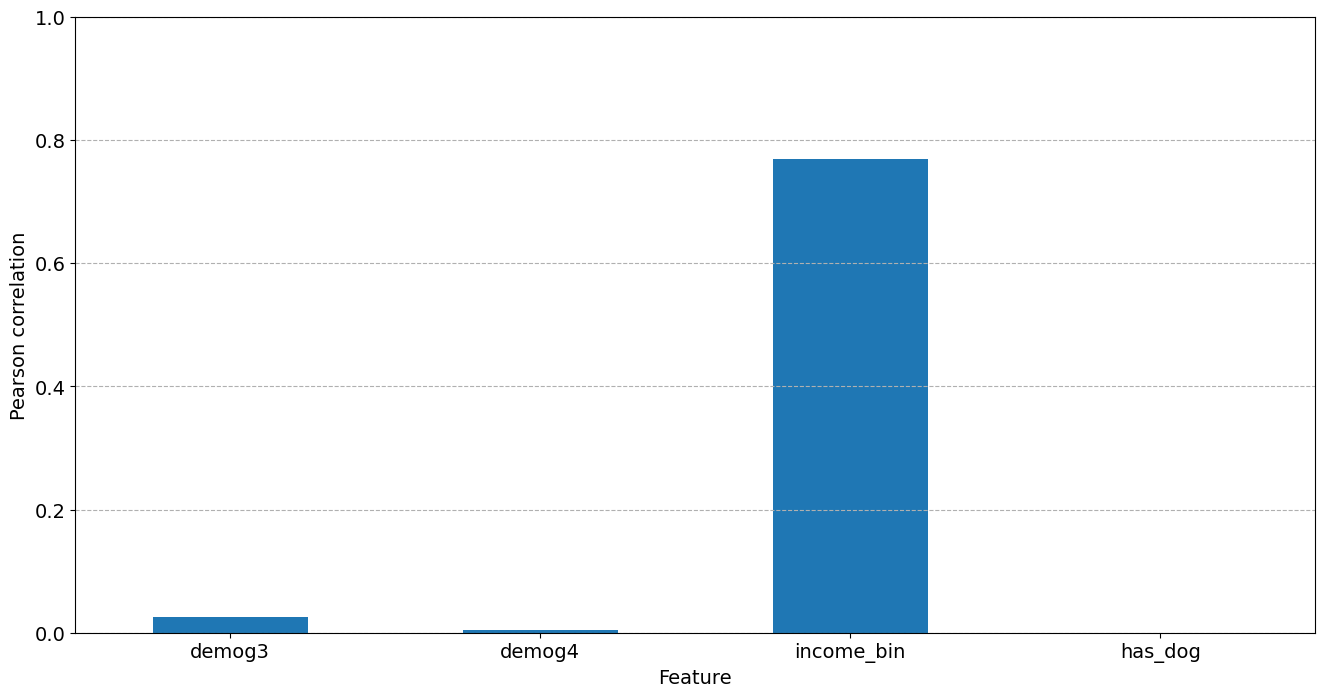

In [41]:
plot.feature_label_correlations(correlations=train_df.corr().y_true.drop("y_true"))

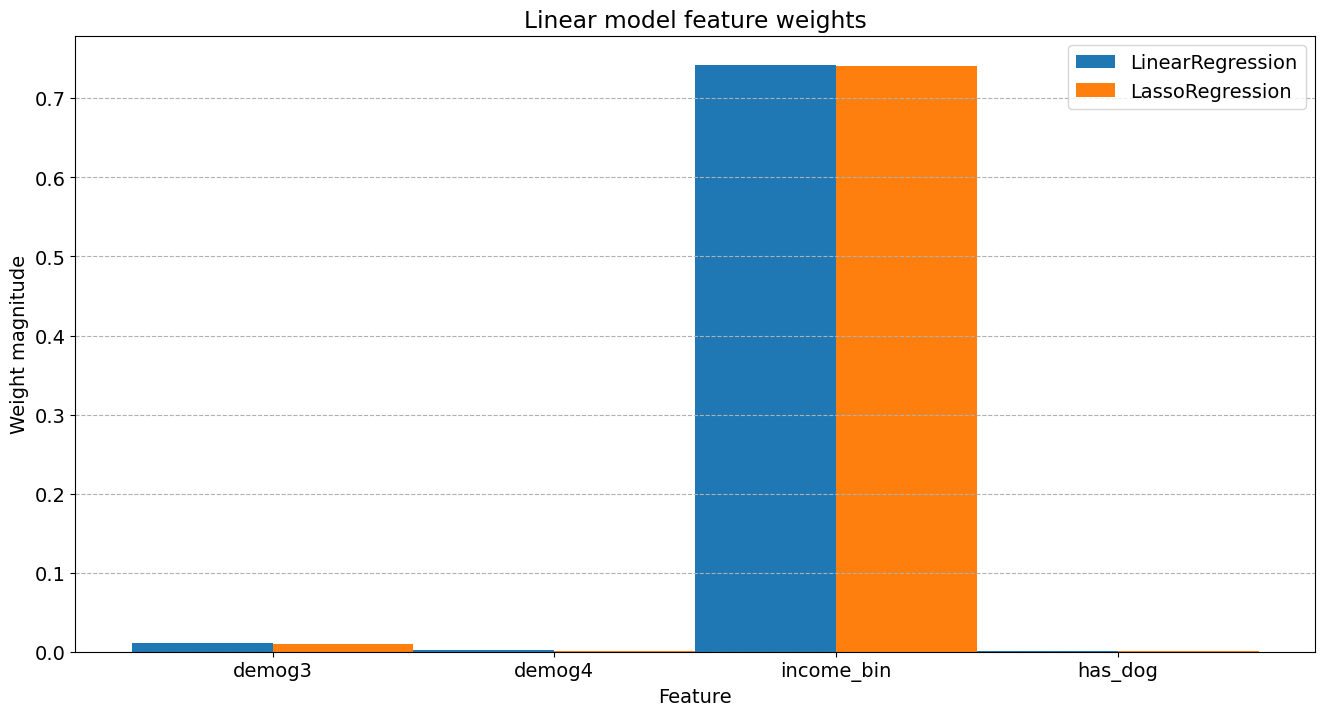

In [42]:
plot.linear_model_weights(
    linear_regression_model_weights=best_models["LinearRegression"][1].coef_,
    lasso_model_weights=best_models["Lasso"][1].coef_,
    feature_names=train_df.columns.drop("y_true"),
)

### Question 4: Key observations and takeaways

- The models appear unable to learn well from the data, exhibiting classic underfitting as they fail to predict across the full range of values observed during training.
- In particular, the models' predictions appear "binned", with most models' predictions falling into 5 distinct clusters in label space.
- 4 features were used to fit the models: `demog3`, `demog4`, `income_bin`, and `has_dog`.
- 3 of these features - `demog3`, `demog4`, and `has_dog` - are uncorrelated with the target.
  - This is illustrated in the lack of any clear relationship in the final row of the scatterplot matrix above.
  - It is also reflected in the low weights assigned to them by the linear models.
- By contrast, `income_bin` does show some association with the target, with a Pearson correlation of just under 0.8.
  - As a result, the models are effectively able to learn from only this variable.
- However, this variable is ordinal, and somewhat categorical in nature, taking on only 5 distinct values: `[1, 2, 3, 4, 5]`.
- I believe this explains the pronounced "binned" nature of the predictions.
  - In effect, the models are being told to predict a continuous value on the basis of just a single scalar value (not literally, but intuitively).
  - It seems that the models exhibit a form of "regression to the mean", learning to predict some average value for each bin.
  - It is not visualized here, but I computed the correlation between each model's predictions and `income_bin`. The results ranged from about 0.60 to 0.99.

In the end, I believe the provided dataset does not yield enough signal to model exposures. My recommendation would be to find better features.